In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42519")
client

<Client: 'tcp://127.0.0.1:42519' processes=8 threads=32, memory=187.54 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:33425' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import qgutils
import xarray as xr
# import zarr
# import shutil
# from rechunker import rechunk
import dask.array as dsar
import os.path as op
# import scipy.sparse as spar
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
ddir = '/bettik/uchidat/qg-ML/'

In [4]:
U     = .1
T     = 5e5    # seconds
L     = U*T
tau0  = .0001
dt    = 5e-2
Rd    = 5e4   # Rossby radius (50km)
Re4   = 4e3
# f0 = 8e-5
beta  = .5
N     = 1024   # Number of horizontal grids
L0    = 80
H     = 5e3
dx    = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny  = 360
Rom   = .025
Ekb   = .002*2
ntime = int(62.2*5)+1

percent = 20
nmemb = 100

ncoars = 4
DX = dx * ncoars

In [5]:
dsb1 = xr.open_dataset(op.join(ddir,"Mean-n04_001.nc")).chunk({'time':9,'YC':128,'XC':128})
dsb1

<xarray.Dataset>
Dimensions:  (XC: 258, YC: 258, Z: 3, time: 312)
Coordinates:
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
  * XC       (XC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
Data variables:
    qb       (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    P0b      (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    P1b      (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    P2b      (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    P3b      (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>

In [6]:
dsp1 = xr.open_dataset(op.join(ddir,"Eddy-n04_001.nc")).chunk({'time':9,'YC':128,'XC':128})
dsp1

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, Z: 3, time: 312)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
Data variables:
    upqp     (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpqp     (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    upP0p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpP0p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    upP1p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpP1p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    upP2p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpP2p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    upP3p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpP3p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>

In [7]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    # if nd == 2:
    #     psi = np.pad(psi,((1,1),(1,1)),'constant')
    if nd < 4:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def _dot2D(self, other):
    func = np.dot(self[0,0], other[0,0])
    
    return func[np.newaxis,np.newaxis,:,:]

In [8]:
P0 = dsb1.P0b.data   
P0x = np.diff(P0[...,1:-1,:], axis=-1) / DX
P0x = xr.DataArray(.5*(P0x[...,1:] + P0x[...,:-1]), 
                   dims=dsb1.P0b.dims, 
                   coords=dsb1.P0b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P0y = np.diff(P0[...,1:-1], axis=-2) / DX
P0y = xr.DataArray(.5*(P0y[...,1:,:] + P0y[...,:-1,:]), 
                   dims=dsb1.P0b.dims, 
                   coords=dsb1.P0b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

P1 = dsb1.P1b.data
P1x = np.diff(P1[...,1:-1,:], axis=-1) / DX
P1x = xr.DataArray(.5*(P1x[...,1:] + P1x[...,:-1]), 
                   dims=dsb1.P1b.dims, 
                   coords=dsb1.P1b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P1y = np.diff(P1[...,1:-1], axis=-2) / DX
P1y = xr.DataArray(.5*(P1y[...,1:,:] + P1y[...,:-1,:]), 
                   dims=dsb1.P1b.dims, 
                   coords=dsb1.P1b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

P2 = dsb1.P2b.data
P2x = np.diff(P2[...,1:-1,:], axis=-1) / DX
P2x = xr.DataArray(.5*(P2x[...,1:] + P2x[...,:-1]), 
                   dims=dsb1.P2b.dims, 
                   coords=dsb1.P2b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P2y = np.diff(P2[...,1:-1], axis=-2) / DX
P2y = xr.DataArray(.5*(P2y[...,1:,:] + P2y[...,:-1,:]), 
                   dims=dsb1.P2b.dims, 
                   coords=dsb1.P2b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

P3 = dsb1.P3b.data  
P3x = np.diff(P3[...,1:-1,:], axis=-1) / DX
P3x = xr.DataArray(.5*(P3x[...,1:] + P3x[...,:-1]), 
                   dims=dsb1.P3b.dims, 
                   coords=dsb1.P3b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P3y = np.diff(P3[...,1:-1], axis=-2) / DX
P3y = xr.DataArray(.5*(P3y[...,1:,:] + P3y[...,:-1,:]), 
                   dims=dsb1.P3b.dims, 
                   coords=dsb1.P3b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

In [9]:
# xlim = [280,340]
dy = 0
# lstart = sstart + 2

tts = 1
for tt in range(1):
    
    for l in range(3):

        uP0 = dsp1.upP0p.isel(time=tt,Z=l)
        vP0 = dsp1.vpP0p.isel(time=tt,Z=l)
        uP1 = dsp1.upP1p.isel(time=tt,Z=l)
        vP1 = dsp1.vpP1p.isel(time=tt,Z=l)
        uP2 = dsp1.upP2p.isel(time=tt,Z=l)
        vP2 = dsp1.vpP2p.isel(time=tt,Z=l)
#         uP3 = dsp1.upP3p.isel(time=tt,Z=l)
#         vP3 = dsp1.vpP3p.isel(time=tt,Z=l)

#################################
        u0_norm = (uP0 * np.nanmedian(np.sqrt(P0x**2 + P0y**2).isel(time=tt,Z=l),
                                      axis=(-2,-1))**-1)
        v0_norm = (vP0 * np.nanmedian(np.sqrt(P0x**2 + P0y**2).isel(time=tt,Z=l),
                                      axis=(-2,-1))**-1)
        u1_norm = (uP1 * np.nanmedian(np.sqrt(P1x**2 + P1y**2).isel(time=tt,Z=l),
                                      axis=(-2,-1))**-1)
        v1_norm = (vP1 * np.nanmedian(np.sqrt(P1x**2 + P1y**2).isel(time=tt,Z=l),
                                      axis=(-2,-1))**-1)
        u2_norm = (uP2 * np.nanmedian(np.sqrt(P2x**2 + P2y**2).isel(time=tt,Z=l),
                                      axis=(-2,-1))**-1)
        v2_norm = (vP2 * np.nanmedian(np.sqrt(P2x**2 + P2y**2).isel(time=tt,Z=l),
                                      axis=(-2,-1))**-1)
#         u3_norm = (uP3 * np.nanmedian(np.sqrt(P3x**2 + P3y**2).isel(time=tt,Z=l),
#                                       axis=(-2,-1))**-1)
#         v3_norm = (vP3 * np.nanmedian(np.sqrt(P3x**2 + P3y**2).isel(time=tt,Z=l),
#                                       axis=(-2,-1))**-1)

        P0x_norm = (P0x.isel(time=tt,Z=l) 
                    * np.nanmedian(np.sqrt(P0x**2 + P0y**2).isel(time=tt,Z=l), 
                                       axis=(-2,-1))**-1)
        P0y_norm = (P0y.isel(time=tt,Z=l) 
                    * np.nanmedian(np.sqrt(P0x**2 + P0y**2).isel(time=tt,Z=l), 
                                       axis=(-2,-1))**-1)
        P1x_norm = (P1x.isel(time=tt,Z=l) 
                    * np.nanmedian(np.sqrt(P1x**2 + P1y**2).isel(time=tt,Z=l), 
                                       axis=(-2,-1))**-1)
        P1y_norm = (P1y.isel(time=tt,Z=l) 
                    * np.nanmedian(np.sqrt(P1x**2 + P1y**2).isel(time=tt,Z=l), 
                                       axis=(-2,-1))**-1)
        P2x_norm = (P2x.isel(time=tt,Z=l) 
                    * np.nanmedian(np.sqrt(P2x**2 + P2y**2).isel(time=tt,Z=l), 
                                       axis=(-2,-1))**-1)
        P2y_norm = (P2y.isel(time=tt,Z=l) 
                    * np.nanmedian(np.sqrt(P2x**2 + P2y**2).isel(time=tt,Z=l), 
                                       axis=(-2,-1))**-1)
#         P3x_norm = (P3x.isel(time=tt,Z=l) 
#                     * np.nanmedian(np.sqrt(P3x**2 + P3y**2).isel(time=tt,Z=l), 
#                                        axis=(-2,-1))**-1)
#         P3y_norm = (P3y.isel(time=tt,Z=l) 
#                     * np.nanmedian(np.sqrt(P3x**2 + P3y**2).isel(time=tt,Z=l), 
#                                        axis=(-2,-1))**-1)

#################################
        if l == 0:
            K = xr.DataArray(np.ones((len(dsp1.Z.data),
                                      len(uP0.YC.data),
                                      len(uP0.XC.data),
                                      2,2))*np.nan,
                             dims=['Z','YC','XC','col','row'],
                             coords={'YC':uP0.YC.data,
                                     'XC':uP0.XC.data,
                                     'Z':dsp1.Z.data}
                            )

        G = xr.DataArray(np.zeros((len(uP0.YC.data),
                                   len(uP0.XC.data),
                                   3,2)),
                         dims=['YC','XC','row','col']
                        )
        G[:,:,0,0] = -P0x_norm
        G[:,:,0,1] = -P0y_norm
        G[:,:,1,0] = -P1x_norm
        G[:,:,1,1] = -P1y_norm
        G[:,:,2,0] = -P2x_norm
        G[:,:,2,1] = -P2y_norm
#         G[:,:,3,0] = -P3x_norm
#         G[:,:,3,1] = -P3y_norm

#         G = G.fillna(0.)

        invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                            G.chunk({'YC':1,'XC':1}).data).compute(),
                            dims=['YC','XC','row','col']
                           )
        del G

        F = xr.DataArray(np.zeros((len(uP0.YC.data),
                                   len(uP0.XC.data),
                                   3,2)),
                         dims=['YC','XC','row','col']
                        )
        F[:,:,0,0] = u0_norm
        F[:,:,0,1] = v0_norm
        F[:,:,1,0] = u1_norm
        F[:,:,1,1] = v1_norm
        F[:,:,2,0] = u2_norm
        F[:,:,2,1] = v2_norm
#         F[:,:,3,0] = u3_norm
#         F[:,:,3,1] = v3_norm

#         F = F.fillna(0.)

        K[dict(Z=l)] = dsar.map_blocks(_dot2D, invG.chunk({'YC':1,'XC':1}).data, 
                                       F.chunk({'YC':1,'XC':1}).data,
                                       chunks=(1,1,2,2)
                                      ).compute()
        if tt == 0 and l == 0:
            K.isel(Z=l)[:,:,0,0].plot(vmax=1e2)
            plt.show()

        del F, invG
#         print(l)

    K.chunk({'Z':1,'YC':128,'XC':128}).to_dataset(name='K').to_zarr(op.join(ddir,
                                           'Diff-tensor/nC%02d/Three-out-of-four/%010d.zarr'
                                           % (ncoars,tt)),
                                   mode='w')
    print(tt)

0


In [11]:
K = xr.open_zarr(op.join(ddir,'Diff-tensor/nC%02d/Three-out-of-four/%010d.zarr'
                         % (ncoars,0))
                ).K
K

<xarray.DataArray 'K' (Z: 3, YC: 256, XC: 256, col: 2, row: 2)>
dask.array<open_dataset-c7371ae5c253fd9c4f892003a75c2d9bK, shape=(3, 256, 256, 2, 2), dtype=float64, chunksize=(1, 128, 128, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
Dimensions without coordinates: col, row

/tmp/ipykernel_22083/1787260883.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=0)[...,0,0]*U*L,
/tmp/ipykernel_22083/1787260883.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=0)[...,1,0]*U*L,
/tmp/ipykernel_22083/1787260883.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated si

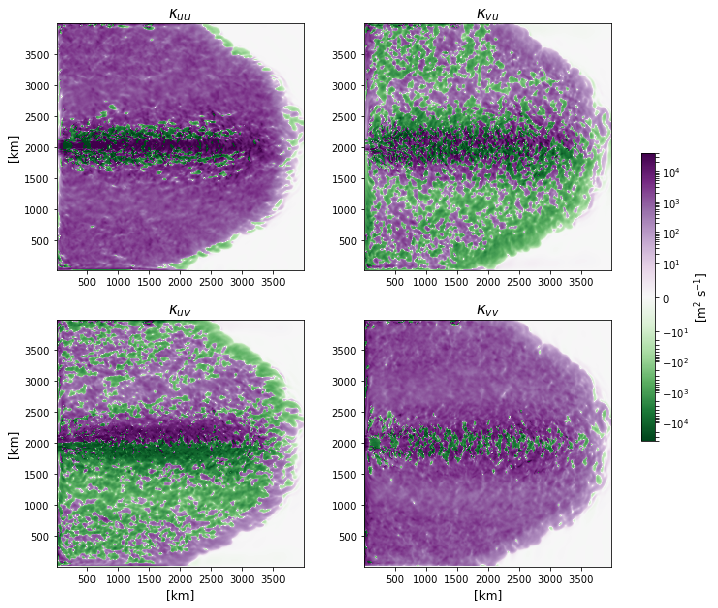

In [30]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=0)[...,0,0]*U*L,
                          cmap='PRGn_r', 
                          norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                          rasterized=True
                         )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=0)[...,1,0]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=0)[...,0,1]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=0)[...,1,1]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\kappa_{uu}$", fontsize=15)
axes[1,0].set_title(r"$\kappa_{uv}$", fontsize=15)
axes[0,1].set_title(r"$\kappa_{vu}$", fontsize=15)
axes[1,1].set_title(r"$\kappa_{vv}$", fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2, wspace=.12)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/Kappa_Z=0_3-4_%010d.pdf' % 0))

/tmp/ipykernel_22083/3651328620.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=1)[...,0,0]*U*L,
/tmp/ipykernel_22083/3651328620.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=1)[...,1,0]*U*L,
/tmp/ipykernel_22083/3651328620.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated si

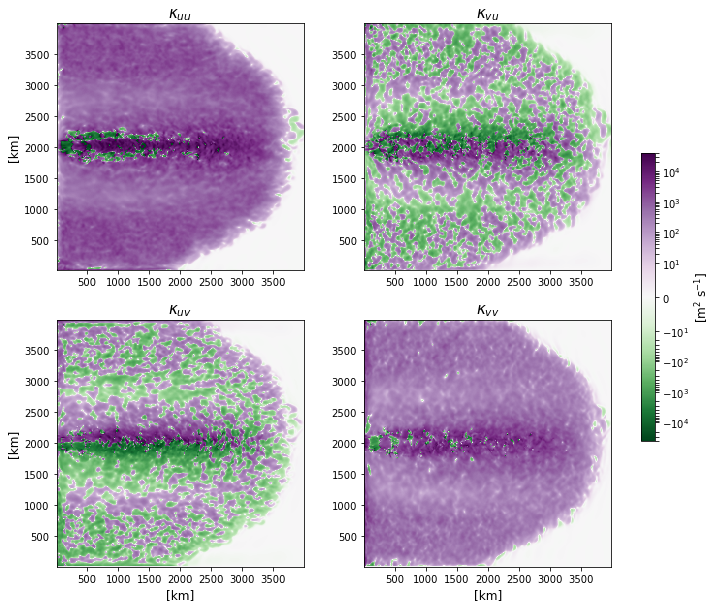

In [29]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=1)[...,0,0]*U*L,
                          cmap='PRGn_r', 
                          norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                          rasterized=True
                         )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=1)[...,1,0]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=1)[...,0,1]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=1)[...,1,1]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\kappa_{uu}$", fontsize=15)
axes[1,0].set_title(r"$\kappa_{uv}$", fontsize=15)
axes[0,1].set_title(r"$\kappa_{vu}$", fontsize=15)
axes[1,1].set_title(r"$\kappa_{vv}$", fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2, wspace=.12)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/Kappa_Z=1_3-4_%010d.pdf' % 0))

/tmp/ipykernel_22083/1835518062.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=2)[...,0,0]*U*L,
/tmp/ipykernel_22083/1835518062.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=2)[...,1,0]*U*L,
/tmp/ipykernel_22083/1835518062.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated si

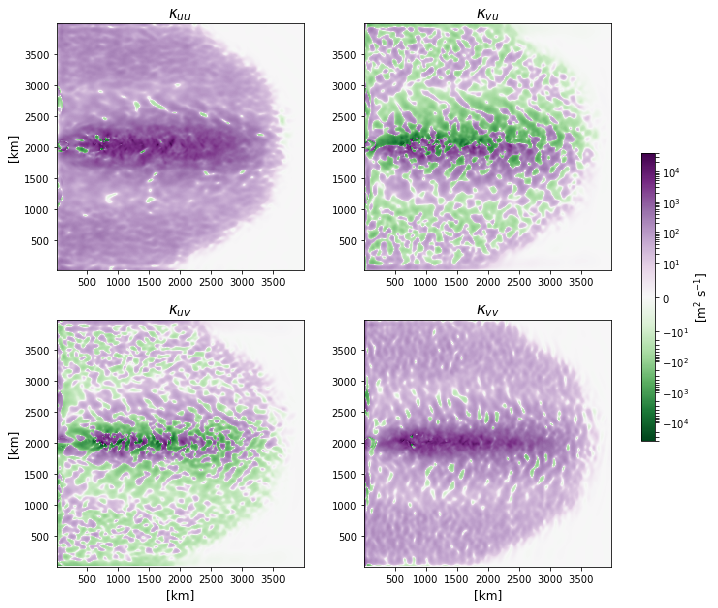

In [28]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=2)[...,0,0]*U*L,
                          cmap='PRGn_r', 
                          norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                          rasterized=True
                         )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=2)[...,1,0]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=2)[...,0,1]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, K.isel(Z=2)[...,1,1]*U*L,
                     cmap='PRGn_r', 
                     norm=clr.SymLogNorm(vmax=4e4, vmin=-4e4, linthresh=1e1),
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\kappa_{uu}$", fontsize=15)
axes[1,0].set_title(r"$\kappa_{uv}$", fontsize=15)
axes[0,1].set_title(r"$\kappa_{vu}$", fontsize=15)
axes[1,1].set_title(r"$\kappa_{vv}$", fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2, wspace=.12)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/Kappa_Z=2_3-4_%010d.pdf' % 0))

/tmp/ipykernel_22083/4147263612.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/4147263612.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/4147263612.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrila

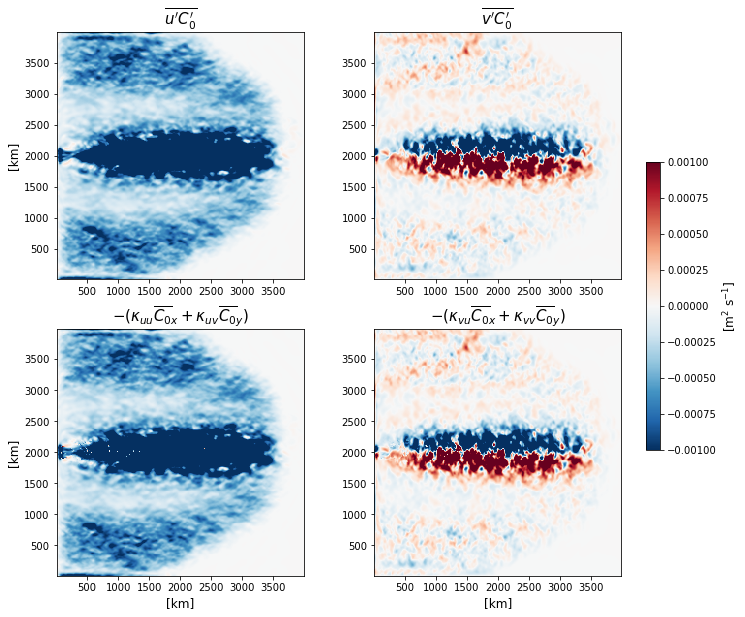

In [15]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          dsp1.upP0p.isel(time=0,Z=1)*U,
                          cmap='RdBu_r', 
                          vmax=1e-3, vmin=-1e-3,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     dsp1.vpP0p.isel(time=0,Z=1)*U,
                     cmap='RdBu_r', 
                     vmax=1e-3, vmin=-1e-3,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=1)[...,0,0] * P0x.isel(time=0,Z=1)
                       + K.isel(Z=1)[...,1,0] * P0y.isel(time=0,Z=1)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=1e-3, vmin=-1e-3,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=1)[...,0,1] * P0x.isel(time=0,Z=1)
                       + K.isel(Z=1)[...,1,1] * P0y.isel(time=0,Z=1)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=1e-3, vmin=-1e-3,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{u'C_0'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'C_0'}$", fontsize=15)
axes[1,0].set_title(r"$-(\kappa_{uu}\overline{C_0}_x + \kappa_{uv}\overline{C_0}_y)$", 
                    fontsize=15)
axes[1,1].set_title(r"$-(\kappa_{vu}\overline{C_0}_x + \kappa_{vv}\overline{C_0}_y)$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/upP0p_Z=1_3-4_%010d.pdf' % 0))

/tmp/ipykernel_22083/3469499250.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/3469499250.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/3469499250.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadril

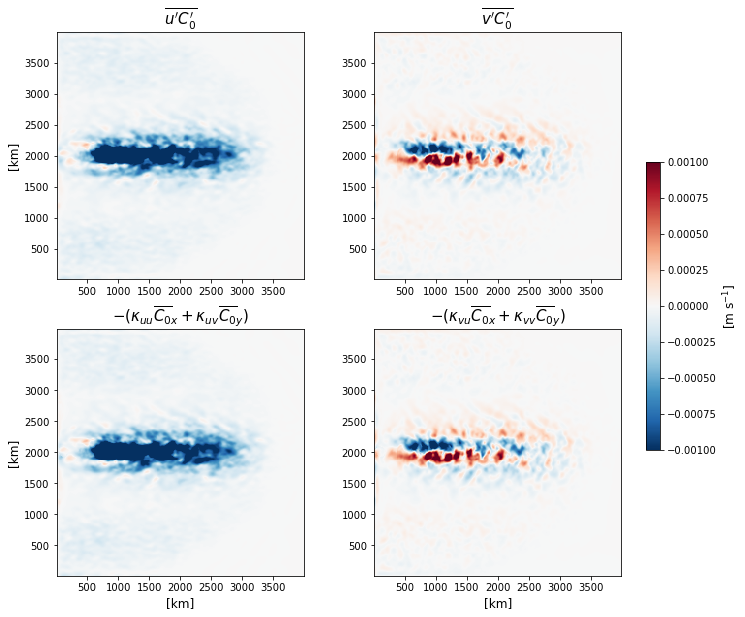

In [16]:
l = 2
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          dsp1.upP0p.isel(time=0,Z=l)*U,
                          cmap='RdBu_r', 
                          vmax=1e-3, vmin=-1e-3,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     dsp1.vpP0p.isel(time=0,Z=l)*U,
                     cmap='RdBu_r', 
                     vmax=1e-3, vmin=-1e-3,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,0] * P0x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,0] * P0y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=1e-3, vmin=-1e-3,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,1] * P0x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,1] * P0y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=1e-3, vmin=-1e-3,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{u'C_0'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'C_0'}$", fontsize=15)
axes[1,0].set_title(r"$-(\kappa_{uu}\overline{C_0}_x + \kappa_{uv}\overline{C_0}_y)$", 
                    fontsize=15)
axes[1,1].set_title(r"$-(\kappa_{vu}\overline{C_0}_x + \kappa_{vv}\overline{C_0}_y)$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/upP0p_Z=%1d_3-4_%010d.pdf' % (l,0)))

/tmp/ipykernel_22083/3781842654.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/3781842654.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/3781842654.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadril

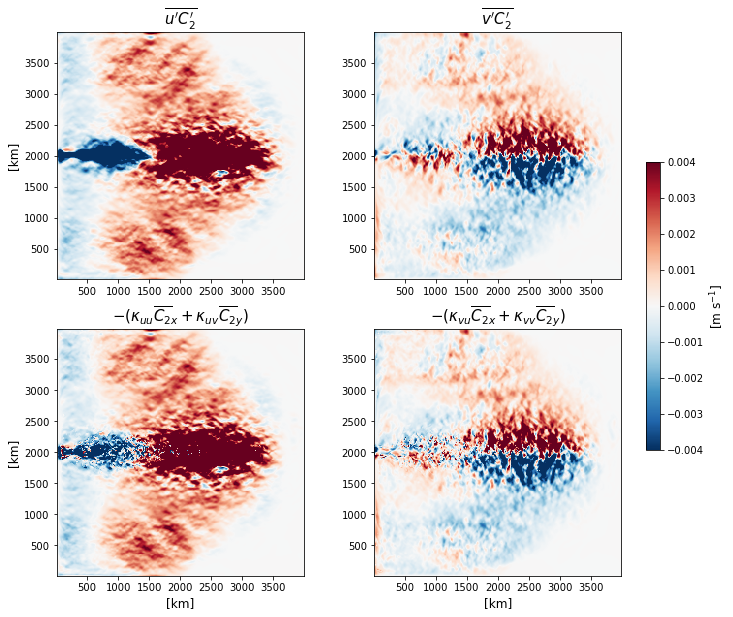

In [17]:
l = 0
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          dsp1.upP2p.isel(time=0,Z=l)*U,
                          cmap='RdBu_r', 
                          vmax=4e-3, vmin=-4e-3,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     dsp1.vpP2p.isel(time=0,Z=l)*U,
                     cmap='RdBu_r', 
                     vmax=4e-3, vmin=-4e-3,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,0] * P2x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,0] * P2y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=4e-3, vmin=-4e-3,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,1] * P2x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,1] * P2y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=4e-3, vmin=-4e-3,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{u'C_2'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'C_2'}$", fontsize=15)
axes[1,0].set_title(r"$-(\kappa_{uu}\overline{C_2}_x + \kappa_{uv}\overline{C_2}_y)$", 
                    fontsize=15)
axes[1,1].set_title(r"$-(\kappa_{vu}\overline{C_2}_x + \kappa_{vv}\overline{C_2}_y)$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/upP2p_Z=%1d_3-4_%010d.pdf' % (l,0)))

/tmp/ipykernel_22083/421234774.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/421234774.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/421234774.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilate

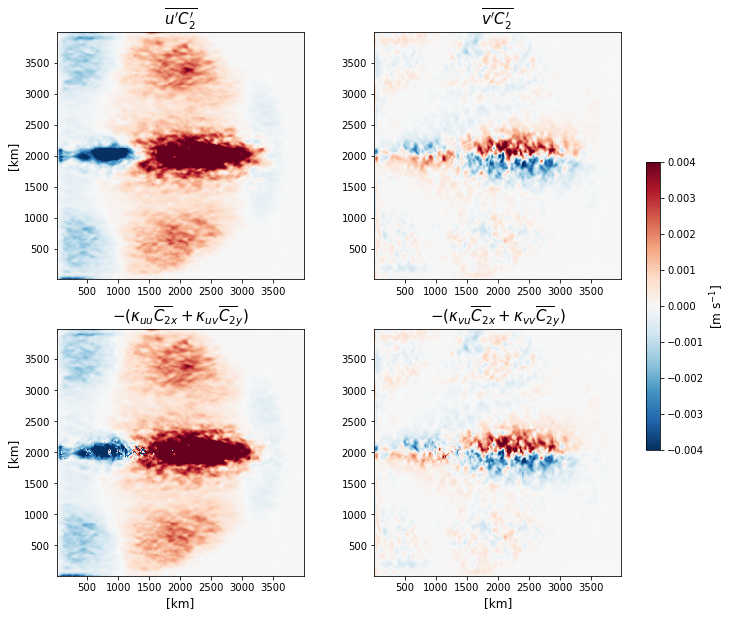

In [18]:
l = 1
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          dsp1.upP2p.isel(time=0,Z=l)*U,
                          cmap='RdBu_r', 
                          vmax=4e-3, vmin=-4e-3,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     dsp1.vpP2p.isel(time=0,Z=l)*U,
                     cmap='RdBu_r', 
                     vmax=4e-3, vmin=-4e-3,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,0] * P2x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,0] * P2y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=4e-3, vmin=-4e-3,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,1] * P2x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,1] * P2y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=4e-3, vmin=-4e-3,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{u'C_2'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'C_2'}$", fontsize=15)
axes[1,0].set_title(r"$-(\kappa_{uu}\overline{C_2}_x + \kappa_{uv}\overline{C_2}_y)$", 
                    fontsize=15)
axes[1,1].set_title(r"$-(\kappa_{vu}\overline{C_2}_x + \kappa_{vv}\overline{C_2}_y)$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/upP2p_Z=%1d_3-4_%010d.pdf' % (l,0)))

/tmp/ipykernel_22083/4244284723.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/4244284723.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/4244284723.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadril

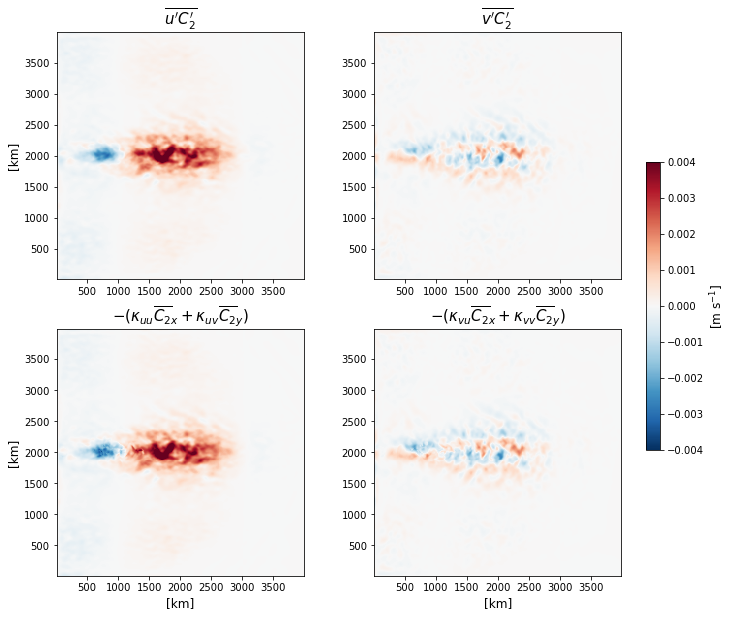

In [19]:
l = 2
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          dsp1.upP2p.isel(time=0,Z=l)*U,
                          cmap='RdBu_r', 
                          vmax=4e-3, vmin=-4e-3,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     dsp1.vpP2p.isel(time=0,Z=l)*U,
                     cmap='RdBu_r', 
                     vmax=4e-3, vmin=-4e-3,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,0] * P2x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,0] * P2y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=4e-3, vmin=-4e-3,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,1] * P2x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,1] * P2y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=4e-3, vmin=-4e-3,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{u'C_2'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'C_2'}$", fontsize=15)
axes[1,0].set_title(r"$-(\kappa_{uu}\overline{C_2}_x + \kappa_{uv}\overline{C_2}_y)$", 
                    fontsize=15)
axes[1,1].set_title(r"$-(\kappa_{vu}\overline{C_2}_x + \kappa_{vv}\overline{C_2}_y)$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/upP2p_Z=%1d_3-4_%010d.pdf' % (l,0)))

/tmp/ipykernel_22083/363177430.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/363177430.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_22083/363177430.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilate

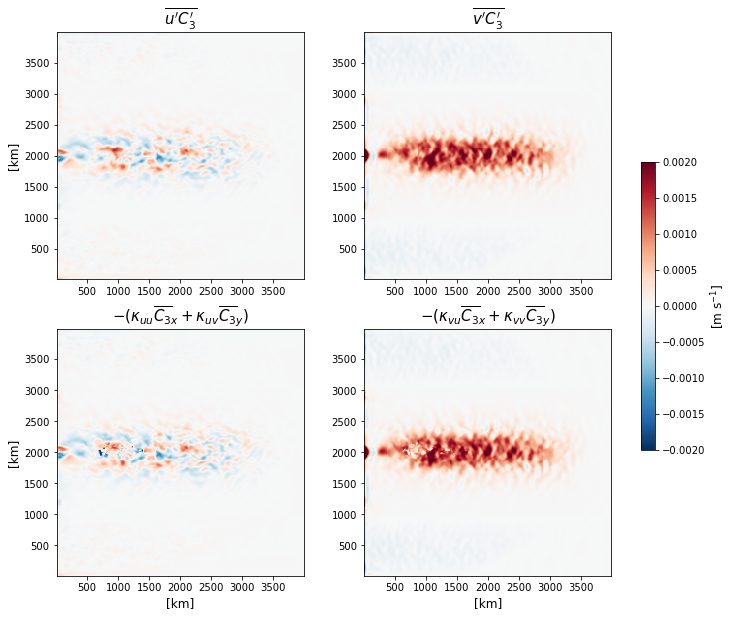

In [27]:
l = 2
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          dsp1.upP3p.isel(time=0,Z=l)*U,
                          cmap='RdBu_r', 
                          vmax=2e-3, vmin=-2e-3,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     dsp1.vpP3p.isel(time=0,Z=l)*U,
                     cmap='RdBu_r', 
                     vmax=2e-3, vmin=-2e-3,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,0] * P3x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,0] * P3y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=2e-3, vmin=-2e-3,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,1] * P3x.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,1] * P3y.isel(time=0,Z=l)
                      )*U,
                     cmap='RdBu_r', 
                     vmax=2e-3, vmin=-2e-3,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{u'C_3'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'C_3'}$", fontsize=15)
axes[1,0].set_title(r"$-(\kappa_{uu}\overline{C_3}_x + \kappa_{uv}\overline{C_3}_y)$", 
                    fontsize=15)
axes[1,1].set_title(r"$-(\kappa_{vu}\overline{C_3}_x + \kappa_{vv}\overline{C_3}_y)$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2, wspace=.12)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/upP3p_Z=%1d_3-4_%010d.pdf' % (l,0)))

# Spatial correlation

$$ r = \frac{\sum[(F^\text{true} - \langle F^\text{true}\rangle) (F^\text{param} - \langle F^\text{param}\rangle)]}{\sqrt{\sum[(F^\text{true} - \langle F^\text{true}\rangle)^2]}\sqrt{\sum[(F^\text{param} - \langle F^\text{param}\rangle)^2]}} $$

In [34]:
uP0_ = dsp1.upP0p.isel(time=0).mean(['YC','XC'],skipna=True)
Fx0 = -(K[...,0,0] * P0x.isel(time=0)
        + K[...,1,0] * P0y.isel(time=0)
       )
Fx0_ = Fx0.mean(['YC','XC'],skipna=True)
rx01 = (dsp1.upP0p.isel(time=0) - uP0_)
rx02 = (Fx0 - Fx0_)

vP0_ = dsp1.vpP0p.isel(time=0).mean(['YC','XC'],skipna=True)
Fy0 = -(K[...,0,1] * P0x.isel(time=0)
        + K[...,1,1] * P0y.isel(time=0)
       )
Fy0_ = Fy0.mean(['YC','XC'],skipna=True)
ry01 = (dsp1.vpP0p.isel(time=0) - vP0_)
ry02 = (Fy0 - Fy0_)

R0x = ((rx01*rx02).sum(['YC','XC'],skipna=True)
       / (np.sqrt((rx01**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((rx02**2).sum(['YC','XC'],skipna=True)))
      ).compute()
R0y = ((ry01*ry02).sum(['YC','XC'],skipna=True)
       / (np.sqrt((ry01**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((ry02**2).sum(['YC','XC'],skipna=True)))
      ).compute()
############################################################
uP1_ = dsp1.upP1p.isel(time=0).mean(['YC','XC'],skipna=True)
Fx1 = -(K[...,0,0] * P1x.isel(time=0)
        + K[...,1,0] * P1y.isel(time=0)
       )
Fx1_ = Fx1.mean(['YC','XC'],skipna=True)
rx11 = (dsp1.upP1p.isel(time=0) - uP1_)
rx12 = (Fx1 - Fx1_)

vP1_ = dsp1.vpP1p.isel(time=0).mean(['YC','XC'],skipna=True)
Fy1 = -(K[...,0,1] * P1x.isel(time=0)
        + K[...,1,1] * P1y.isel(time=0)
       )
Fy1_ = Fy1.mean(['YC','XC'],skipna=True)
ry11 = (dsp1.vpP1p.isel(time=0) - vP1_)
ry12 = (Fy1 - Fy1_)

R1x = ((rx11*rx12).sum(['YC','XC'],skipna=True)
       / (np.sqrt((rx11**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((rx12**2).sum(['YC','XC'],skipna=True)))
      ).compute()
R1y = ((ry11*ry12).sum(['YC','XC'],skipna=True)
       / (np.sqrt((ry11**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((ry12**2).sum(['YC','XC'],skipna=True)))
      ).compute()
############################################################
uP2_ = dsp1.upP2p.isel(time=0).mean(['YC','XC'],skipna=True)
Fx2 = -(K[...,0,0] * P2x.isel(time=0)
        + K[...,1,0] * P2y.isel(time=0)
       )
Fx2_ = Fx2.mean(['YC','XC'],skipna=True)
rx21 = (dsp1.upP2p.isel(time=0) - uP2_)
rx22 = (Fx2 - Fx2_)

vP2_ = dsp1.vpP2p.isel(time=0).mean(['YC','XC'],skipna=True)
Fy2 = -(K[...,0,1] * P2x.isel(time=0)
        + K[...,1,1] * P2y.isel(time=0)
       )
Fy2_ = Fy2.mean(['YC','XC'],skipna=True)
ry21 = (dsp1.vpP2p.isel(time=0) - vP2_)
ry22 = (Fy2 - Fy2_)

R2x = ((rx21*rx22).sum(['YC','XC'],skipna=True)
       / (np.sqrt((rx21**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((rx22**2).sum(['YC','XC'],skipna=True)))
      ).compute()
R2y = ((ry21*ry22).sum(['YC','XC'],skipna=True)
       / (np.sqrt((ry21**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((ry22**2).sum(['YC','XC'],skipna=True)))
      ).compute()
############################################################
uP3_ = dsp1.upP3p.isel(time=0).mean(['YC','XC'],skipna=True)
Fx3 = -(K[...,0,0] * P3x.isel(time=0)
        + K[...,1,0] * P3y.isel(time=0)
       )
Fx3_ = Fx3.mean(['YC','XC'],skipna=True)
rx31 = (dsp1.upP3p.isel(time=0) - uP3_)
rx32 = (Fx3 - Fx3_)

vP3_ = dsp1.vpP3p.isel(time=0).mean(['YC','XC'],skipna=True)
Fy3 = -(K[...,0,1] * P3x.isel(time=0)
        + K[...,1,1] * P3y.isel(time=0)
       )
Fy3_ = Fy3.mean(['YC','XC'],skipna=True)
ry31 = (dsp1.vpP3p.isel(time=0) - vP3_)
ry32 = (Fy3 - Fy3_)

R3x = ((rx31*rx32).sum(['YC','XC'],skipna=True)
       / (np.sqrt((rx31**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((rx32**2).sum(['YC','XC'],skipna=True)))
      ).compute()
R3y = ((ry31*ry32).sum(['YC','XC'],skipna=True)
       / (np.sqrt((ry31**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((ry32**2).sum(['YC','XC'],skipna=True)))
      ).compute()

In [35]:
print(R0x, R0y)
print(R1x, R1y)
print(R2x, R2y)
print(R3x, R3y)

<xarray.DataArray (Z: 3)>
array([0.95240789, 0.98917352, 0.99882835])
Coordinates:
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
    time     float64 311.0 <xarray.DataArray (Z: 3)>
array([0.95742805, 0.98959523, 0.99605371])
Coordinates:
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
    time     float64 311.0
<xarray.DataArray (Z: 3)>
array([0.98020199, 0.96644761, 0.98148642])
Coordinates:
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
    time     float64 311.0 <xarray.DataArray (Z: 3)>
array([0.99914868, 0.99900383, 0.9973292 ])
Coordinates:
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
    time     float64 311.0
<xarray.DataArray (Z: 3)>
array([0.93892594, 0.97843772, 0.99381654])
Coordinates:
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
    time     float64 311.0 <xarray.DataArray (Z: 3)>
array([0.94938911, 0.96615203, 0.9

In [21]:
# tt = 0
Q = dsb1.qb.data   
Qx = np.diff(Q[...,1:-1,:], axis=-1) / DX
Qx = xr.DataArray(.5*(Qx[...,1:] + Qx[...,:-1]), 
                  dims=dsb1.qb.dims, 
                  coords=dsb1.qb.isel(YC=slice(1,-1),
                                      XC=slice(1,-1)).coords
                 ).chunk({'YC':128,'XC':128})
Qy = np.diff(Q[...,1:-1], axis=-2) / DX
Qy = xr.DataArray(.5*(Qy[...,1:,:] + Qy[...,:-1,:]), 
                  dims=dsb1.qb.dims, 
                  coords=dsb1.qb.isel(YC=slice(1,-1),
                                      XC=slice(1,-1)).coords
                 ).chunk({'YC':128,'XC':128})
Q

dask.array<xarray-qb, shape=(312, 3, 258, 258), dtype=float32, chunksize=(9, 3, 128, 128), chunktype=numpy.ndarray>

In [38]:
uQ_ = dsp1.upqp.isel(time=0).mean(['YC','XC'],skipna=True)
FxQ = -(K[...,0,0] * Qx.isel(time=0)
        + K[...,1,0] * Qy.isel(time=0)
       )
FxQ_ = FxQ.mean(['YC','XC'],skipna=True)
rxQ1 = (dsp1.upqp.isel(time=0) - uQ_)
rxQ2 = (FxQ - FxQ_)

vQ_ = dsp1.vpqp.isel(time=0).mean(['YC','XC'],skipna=True)
FyQ = -(K[...,0,1] * Qx.isel(time=0)
        + K[...,1,1] * Qy.isel(time=0)
       )
FyQ_ = FyQ.mean(['YC','XC'],skipna=True)
ryQ1 = (dsp1.vpqp.isel(time=0) - vQ_)
ryQ2 = (FyQ - FyQ_)

RQx = ((rxQ1*rxQ2).sum(['YC','XC'],skipna=True)
       / (np.sqrt((rxQ1**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((rxQ2**2).sum(['YC','XC'],skipna=True)))
      ).compute()
RQy = ((ryQ1*ryQ2).sum(['YC','XC'],skipna=True)
       / (np.sqrt((ryQ1**2).sum(['YC','XC'],skipna=True))
          * np.sqrt((ryQ2**2).sum(['YC','XC'],skipna=True)))
      ).compute()

In [39]:
print(RQx, RQy)

<xarray.DataArray (Z: 3)>
array([0.84395404, 0.08389749, 0.00923942])
Coordinates:
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
    time     float64 311.0 <xarray.DataArray (Z: 3)>
array([0.90642264, 0.0379023 , 0.05136047])
Coordinates:
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
    time     float64 311.0


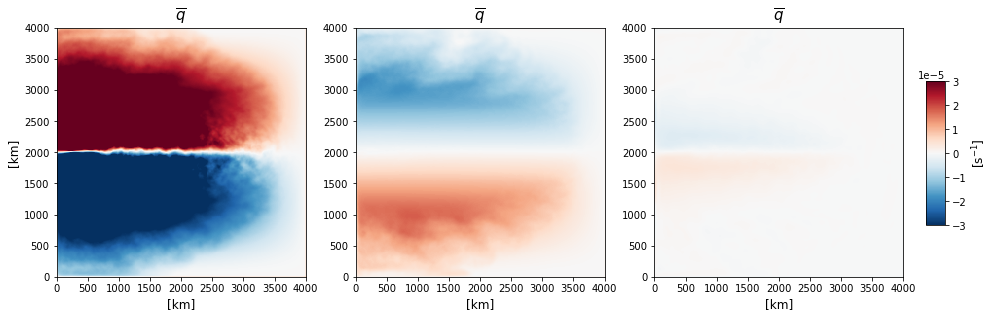

In [34]:
fig, axes = plt.subplots(figsize=(16,5), nrows=1, ncols=3)

axes[0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                   dsb1.qb.isel(time=0,Z=0,YC=slice(1,-1),
                                XC=slice(1,-1))/T,
                   cmap='RdBu_r', 
                   vmax=3e-5, vmin=-3e-5,
                   rasterized=True
                  )
im = axes[1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                        dsb1.qb.isel(time=0,Z=1,YC=slice(1,-1),
                                     XC=slice(1,-1))/T,
                        cmap='RdBu_r', 
                        vmax=3e-5, vmin=-3e-5,
                        rasterized=True
                       )
axes[2].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                   dsb1.qb.isel(time=0,Z=2,YC=slice(1,-1),
                                XC=slice(1,-1))/T,
                   cmap='RdBu_r', 
                   vmax=3e-5, vmin=-3e-5,
                   rasterized=True
                  )

axes[0].set_aspect(1)
axes[1].set_aspect(1)
axes[2].set_aspect(1)

axes[0].set_title(r"$\overline{q}$", fontsize=15)
axes[1].set_title(r"$\overline{q}$", fontsize=15)
axes[2].set_title(r"$\overline{q}$", fontsize=15)

axes[0].set_ylabel(r"[km]", fontsize=12)
axes[0].set_xlabel(r"[km]", fontsize=12)
axes[1].set_xlabel(r"[km]", fontsize=12)
axes[2].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .016, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[s$^{-1}$]", fontsize=12)

# plt.savefig(op.join(ddir,'Figs/upqp_Z=0_%010d.pdf' % 0))

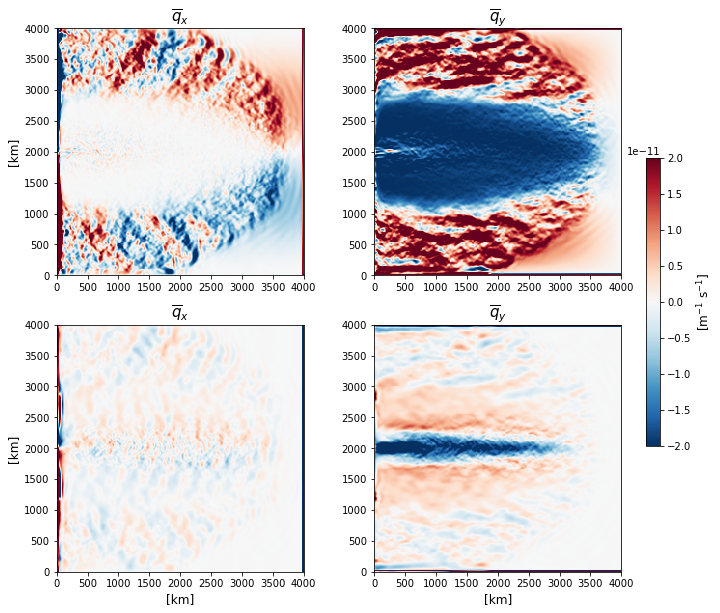

In [21]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          Qx.isel(time=0,Z=1)/T/L,
                          cmap='RdBu_r', 
                          vmax=2e-11, vmin=-2e-11,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     Qy.isel(time=0,Z=1)/T/L,
                     cmap='RdBu_r', 
                     vmax=2e-11, vmin=-2e-11,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     Qx.isel(time=0,Z=2)/T/L,
                     cmap='RdBu_r', 
                     vmax=2e-11, vmin=-2e-11,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     Qy.isel(time=0,Z=2)/T/L,
                     cmap='RdBu_r', 
                     vmax=2e-11, vmin=-2e-11,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{q}_x$", fontsize=15)
axes[0,1].set_title(r"$\overline{q}_y$", fontsize=15)
axes[1,0].set_title(r"$\overline{q}_x$", fontsize=15)
axes[1,1].set_title(r"$\overline{q}_y$", fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m$^{-1}$ s$^{-1}$]", fontsize=12)

# plt.savefig(op.join(ddir,'Figs/upqp_Z=0_%010d.pdf' % 0))

/tmp/ipykernel_255770/271120380.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_255770/271120380.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_255770/271120380.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrila

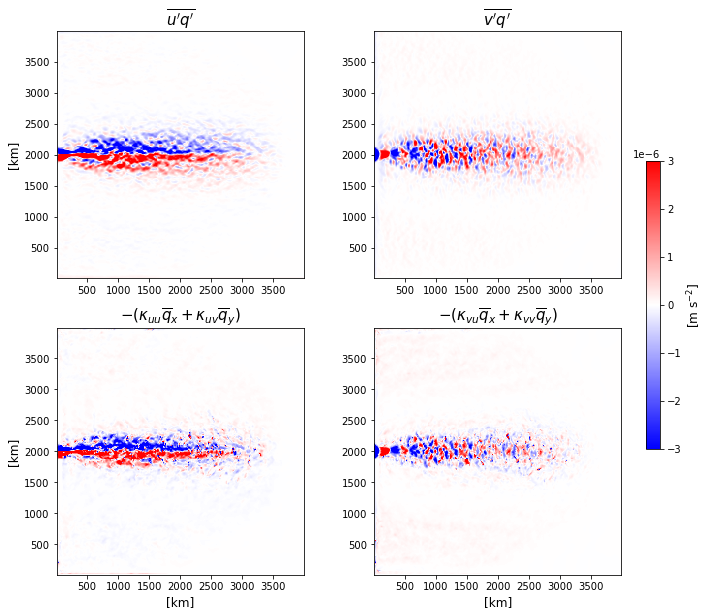

In [29]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          dsp1.upqp.isel(time=0,Z=0)*U/T,
                          cmap='bwr', 
                          vmax=3e-6, vmin=-3e-6,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     dsp1.vpqp.isel(time=0,Z=0)*U/T,
                     cmap='bwr', 
                     vmax=3e-6, vmin=-3e-6,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=0)[...,0,0] * Qx.isel(time=0,Z=0)
                       + K.isel(Z=0)[...,1,0] * Qy.isel(time=0,Z=0)
                      )*U/T,
                     cmap='bwr', 
                          vmax=3e-6, vmin=-3e-6,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=0)[...,0,1] * Qx.isel(time=0,Z=0)
                       + K.isel(Z=0)[...,1,1] * Qy.isel(time=0,Z=0)
                      )*U/T,
                     cmap='bwr', 
                          vmax=3e-6, vmin=-3e-6,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{u'q'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'q'}$", fontsize=15)
axes[1,0].set_title(r"$-(\kappa_{uu}\overline{q}_x + \kappa_{uv}\overline{q}_y)$", 
                    fontsize=15)
axes[1,1].set_title(r"$-(\kappa_{vu}\overline{q}_x + \kappa_{vv}\overline{q}_y)$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/upqp_Z=0_%010d.pdf' % 0))

/tmp/ipykernel_255770/1830463671.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_255770/1830463671.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_255770/1830463671.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadr

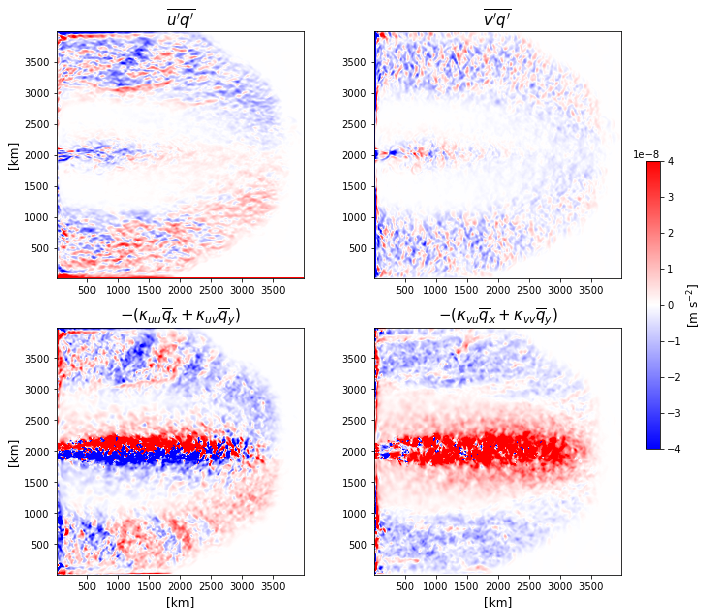

In [31]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          dsp1.upqp.isel(time=0,Z=1)*U/T,
                          cmap='bwr', 
                          vmax=4e-8, vmin=-4e-8,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     dsp1.vpqp.isel(time=0,Z=1)*U/T,
                     cmap='bwr', 
                     vmax=4e-8, vmin=-4e-8,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=1)[...,0,0] * Qx.isel(time=0,Z=1)
                       + K.isel(Z=1)[...,1,0] * Qy.isel(time=0,Z=1)
                      )*U/T,
                     cmap='bwr', 
                     vmax=4e-8, vmin=-4e-8,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=1)[...,0,1] * Qx.isel(time=0,Z=1)
                       + K.isel(Z=1)[...,1,1] * Qy.isel(time=0,Z=1)
                      )*U/T,
                     cmap='bwr', 
                     vmax=4e-8, vmin=-4e-8,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{u'q'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'q'}$", fontsize=15)
axes[1,0].set_title(r"$-(\kappa_{uu}\overline{q}_x + \kappa_{uv}\overline{q}_y)$", 
                    fontsize=15)
axes[1,1].set_title(r"$-(\kappa_{vu}\overline{q}_x + \kappa_{vv}\overline{q}_y)$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/upqp_Z=1_%010d.pdf' % 0))

/tmp/ipykernel_255770/3957164109.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_255770/3957164109.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_255770/3957164109.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quad

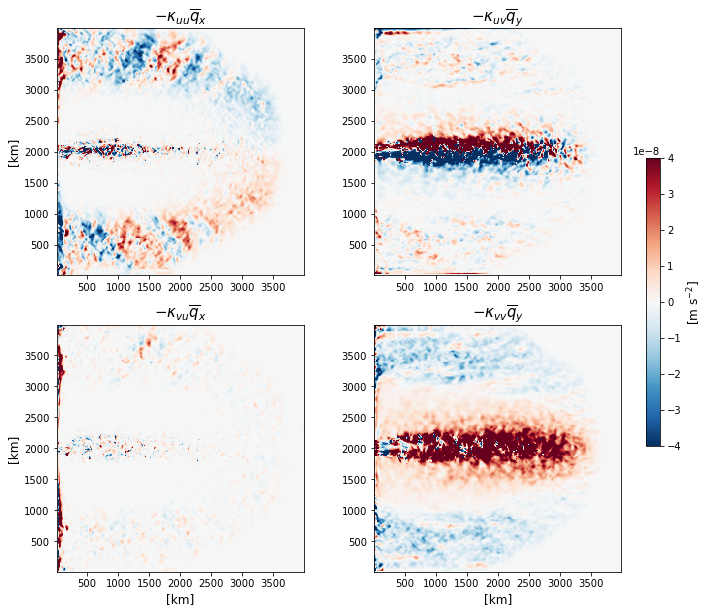

In [24]:
fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          -(K.isel(Z=1)[...,0,0] * Qx.isel(time=0,Z=1)
                            # + K.isel(Z=1)[...,1,0] * Qy.isel(time=0,Z=1)
                           )*U/T,
                          cmap='RdBu_r', 
                          vmax=4e-8, vmin=-4e-8,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(
                         # K.isel(Z=1)[...,0,0] * Qx.isel(time=0,Z=1)
                       + K.isel(Z=1)[...,1,0] * Qy.isel(time=0,Z=1)
                      )*U/T,
                     cmap='RdBu_r', 
                     vmax=4e-8, vmin=-4e-8,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=1)[...,0,1] * Qx.isel(time=0,Z=1)
                       # + K.isel(Z=1)[...,1,0] * Qy.isel(time=0,Z=1)
                      )*U/T,
                     cmap='RdBu_r', 
                     vmax=4e-8, vmin=-4e-8,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(
                         # K.isel(Z=1)[...,0,1] * Qx.isel(time=0,Z=1)
                       + K.isel(Z=1)[...,1,1] * Qy.isel(time=0,Z=1)
                      )*U/T,
                     cmap='RdBu_r', 
                     vmax=4e-8, vmin=-4e-8,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$-\kappa_{uu}\overline{q}_x$", fontsize=15)
axes[0,1].set_title(r"$-\kappa_{uv}\overline{q}_y$", fontsize=15)
axes[1,0].set_title(r"$-\kappa_{vu}\overline{q}_x$", 
                    fontsize=15)
axes[1,1].set_title(r"$-\kappa_{vv}\overline{q}_y$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)

# plt.savefig(op.join(ddir,'Figs/upqp_Z=1_%010d.pdf' % 0))

/tmp/ipykernel_255770/3618371005.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_255770/3618371005.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_255770/3618371005.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quad

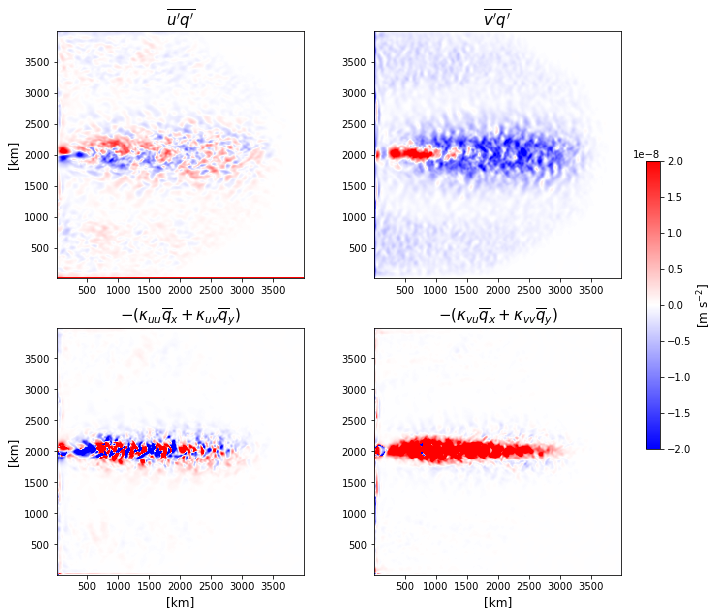

In [32]:
l = 2

fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          dsp1.upqp.isel(time=0,Z=l)*U/T,
                          cmap='bwr', 
                          vmax=2e-8, vmin=-2e-8,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     dsp1.vpqp.isel(time=0,Z=l)*U/T,
                     cmap='bwr', 
                     vmax=2e-8, vmin=-2e-8,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,0] * Qx.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,0] * Qy.isel(time=0,Z=l)
                      )*U/T,
                     cmap='bwr', 
                     vmax=2e-8, vmin=-2e-8,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     -(K.isel(Z=l)[...,0,1] * Qx.isel(time=0,Z=l)
                       + K.isel(Z=l)[...,1,1] * Qy.isel(time=0,Z=l)
                      )*U/T,
                     cmap='bwr', 
                     vmax=2e-8, vmin=-2e-8,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)

axes[0,0].set_title(r"$\overline{u'q'}$", fontsize=15)
axes[0,1].set_title(r"$\overline{v'q'}$", fontsize=15)
axes[1,0].set_title(r"$-(\kappa_{uu}\overline{q}_x + \kappa_{uv}\overline{q}_y)$", 
                    fontsize=15)
axes[1,1].set_title(r"$-(\kappa_{vu}\overline{q}_x + \kappa_{vv}\overline{q}_y)$", 
                    fontsize=15)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_xlabel(r"[km]", fontsize=12)
axes[1,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m s$^{-2}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/upqp_Z=%1d_%010d.pdf' % (l,0)))

In [29]:
upqp_padded = pad_bc(dsp1.upqp.isel(time=0))
vpqp_padded = pad_bc(dsp1.vpqp.isel(time=0))
KQx_padded = pad_bc(-(K[...,0,0] * Qx.isel(time=0)
                       + K[...,1,0] * Qy.isel(time=0)
                     ))
KQy_padded = pad_bc(-(K[...,0,1] * Qx.isel(time=0)
                       + K[...,1,1] * Qy.isel(time=0)
                     ))

upqp_x = np.diff(upqp_padded[...,1:-1,:], axis=-1) / DX
upqp_x = xr.DataArray(.5*(upqp_x[...,1:] + upqp_x[...,:-1]), 
                      dims=dsb1.P0b.isel(time=tt).dims, 
                      coords=dsb1.P0b.isel(time=tt,YC=slice(1,-1),
                                           XC=slice(1,-1)).coords
                     ).chunk({'YC':128,'XC':128})
vpqp_y = np.diff(vpqp_padded[...,1:-1], axis=-2) / DX
vpqp_y = xr.DataArray(.5*(vpqp_y[...,1:,:] + vpqp_y[...,:-1,:]), 
                      dims=dsb1.P0b.isel(time=tt).dims, 
                      coords=dsb1.P0b.isel(time=tt,YC=slice(1,-1),
                                           XC=slice(1,-1)).coords
                     ).chunk({'YC':128,'XC':128})
KQ_x = np.diff(KQx_padded[...,1:-1,:], axis=-1) / DX
KQ_x = xr.DataArray(.5*(KQ_x[...,1:] + KQ_x[...,:-1]), 
                    dims=dsb1.P0b.isel(time=tt).dims, 
                    coords=dsb1.P0b.isel(time=tt,YC=slice(1,-1),
                                         XC=slice(1,-1)).coords
                   ).chunk({'YC':128,'XC':128})
KQ_y = np.diff(KQy_padded[...,1:-1], axis=-2) / DX
KQ_y = xr.DataArray(.5*(KQ_y[...,1:,:] + KQ_y[...,:-1,:]), 
                    dims=dsb1.P0b.isel(time=tt).dims, 
                    coords=dsb1.P0b.isel(time=tt,YC=slice(1,-1),
                                         XC=slice(1,-1)).coords
                   ).chunk({'YC':128,'XC':128})

DF = (upqp_x + vpqp_y)
DKQ = (KQ_x + KQ_y)
DKQ

<xarray.DataArray (Z: 3, YC: 256, XC: 256)>
dask.array<add, shape=(3, 256, 256), dtype=float64, chunksize=(3, 128, 128), chunktype=numpy.ndarray>
Coordinates:
    time     float64 311.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84

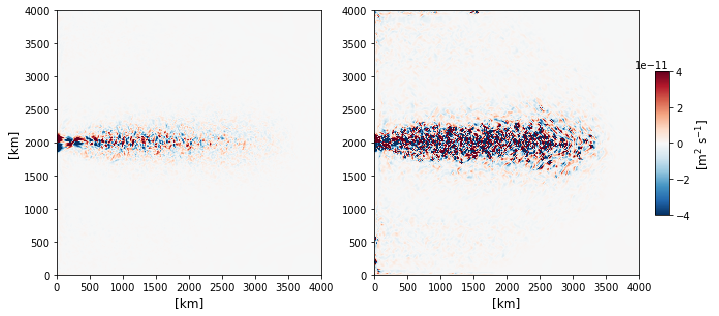

In [33]:
fig, axes = plt.subplots(figsize=(11,5), nrows=1, ncols=2)

im = axes[0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          DF.isel(Z=0)*U/T/L,
                          cmap='RdBu_r', 
                          vmax=4e-11, vmin=-4e-11,
                          rasterized=True
                         )
axes[1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     DKQ.isel(Z=0)*U/T/L,
                     cmap='RdBu_r', 
                     vmax=4e-11, vmin=-4e-11,
                     rasterized=True
                    )

axes[0].set_aspect(1)
axes[1].set_aspect(1)

# axes[0,0].set_title(r"$\overline{u'q'}$", fontsize=15)
# axes[0,1].set_title(r"$\overline{v'q'}$", fontsize=15)
# axes[1,0].set_title(r"$-(\kappa_{uu}\overline{q}_x + \kappa_{uv}\overline{q}_y)$", 
#                     fontsize=15)
# axes[1,1].set_title(r"$-(\kappa_{vu}\overline{q}_x + \kappa_{vv}\overline{q}_y)$", 
#                     fontsize=15)

axes[0].set_ylabel(r"[km]", fontsize=12)
axes[0].set_xlabel(r"[km]", fontsize=12)
axes[1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/Divupqp_Z=0_%010d.pdf' % 0))

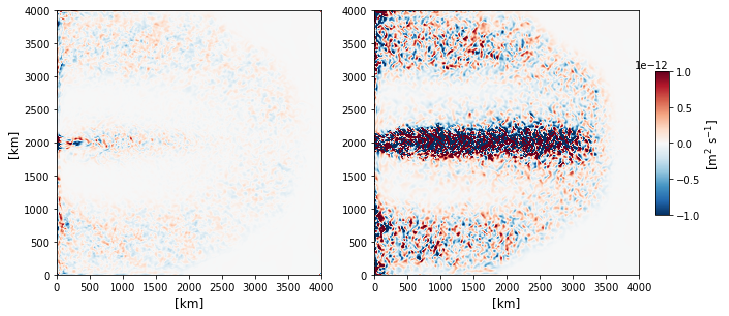

In [35]:
fig, axes = plt.subplots(figsize=(11,5), nrows=1, ncols=2)

im = axes[0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     DF.isel(Z=1)*U/T/L,
                     cmap='RdBu_r', 
                     vmax=1e-12, vmin=-1e-12,
                     rasterized=True
                    )
axes[1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     DKQ.isel(Z=1)*U/T/L,
                     cmap='RdBu_r', 
                     vmax=1e-12, vmin=-1e-12,
                     rasterized=True
                    )

axes[0].set_aspect(1)
axes[1].set_aspect(1)

# axes[0,0].set_title(r"$\overline{u'q'}$", fontsize=15)
# axes[0,1].set_title(r"$\overline{v'q'}$", fontsize=15)
# axes[1,0].set_title(r"$-(\kappa_{uu}\overline{q}_x + \kappa_{uv}\overline{q}_y)$", 
#                     fontsize=15)
# axes[1,1].set_title(r"$-(\kappa_{vu}\overline{q}_x + \kappa_{vv}\overline{q}_y)$", 
#                     fontsize=15)

axes[0].set_ylabel(r"[km]", fontsize=12)
axes[0].set_xlabel(r"[km]", fontsize=12)
axes[1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/Divupqp_Z=1_%010d.pdf' % 0))

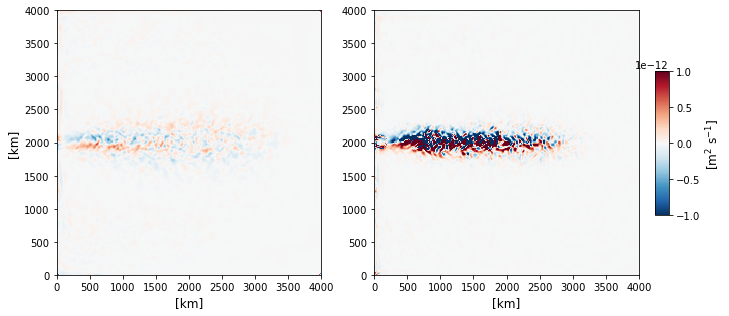

In [36]:
fig, axes = plt.subplots(figsize=(11,5), nrows=1, ncols=2)

im = axes[0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     DF.isel(Z=2)*U/T/L,
                     cmap='RdBu_r', 
                     vmax=1e-12, vmin=-1e-12,
                     rasterized=True
                    )
axes[1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     DKQ.isel(Z=2)*U/T/L,
                     cmap='RdBu_r', 
                     vmax=1e-12, vmin=-1e-12,
                     rasterized=True
                    )

axes[0].set_aspect(1)
axes[1].set_aspect(1)

# axes[0,0].set_title(r"$\overline{u'q'}$", fontsize=15)
# axes[0,1].set_title(r"$\overline{v'q'}$", fontsize=15)
# axes[1,0].set_title(r"$-(\kappa_{uu}\overline{q}_x + \kappa_{uv}\overline{q}_y)$", 
#                     fontsize=15)
# axes[1,1].set_title(r"$-(\kappa_{vu}\overline{q}_x + \kappa_{vv}\overline{q}_y)$", 
#                     fontsize=15)

axes[0].set_ylabel(r"[km]", fontsize=12)
axes[0].set_xlabel(r"[km]", fontsize=12)
axes[1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.2)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
cbar.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/Divupqp_Z=2_%010d.pdf' % 0))

In [9]:
iZ = 0
ntrain = 2

126

In [6]:
nGMM = 15
ver = 1
dsc = xr.open_zarr(op.join(ddir,'EddyPTRCluster/GMM%02d/%03d/Z%02d/' % (nGMM,ver,iZ)))
dsc

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, time: 126)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * time     (time) float64 497.0 498.0 499.0 500.0 ... 619.0 620.0 621.0 622.0
Data variables:
    cluster  (time, YC, XC) int64 dask.array<chunksize=(126, 128, 128), meta=np.ndarray>

In [8]:
P0 = pad_bc(dsb1.P0b)    
P0x = np.diff(P0[...,1:-1,:], axis=-1) / DX
P0x = xr.DataArray(.5*(P0x[...,1:] + P0x[...,:-1]), dims=dsb1.P0b.dims, coords=dsb1.P0b.coords
                  ).chunk({'time':9,'YC':128,'XC':128})
P0y = np.diff(P0[...,1:-1], axis=-2) / DX
P0y = xr.DataArray(.5*(P0y[...,1:,:] + P0y[...,:-1,:]), dims=dsb1.P0b.dims, coords=dsb1.P0b.coords
                  ).chunk({'time':9,'YC':128,'XC':128})

P1 = pad_bc(dsb1.P1b)    
P1x = np.diff(P1[...,1:-1,:], axis=-1) / DX
P1x = xr.DataArray(.5*(P1x[...,1:] + P1x[...,:-1]), dims=dsb1.P1b.dims, coords=dsb1.P1b.coords
                  ).chunk({'time':9,'YC':128,'XC':128})
P1y = np.diff(P1[...,1:-1], axis=-2) / DX
P1y = xr.DataArray(.5*(P1y[...,1:,:] + P1y[...,:-1,:]), dims=dsb1.P1b.dims, coords=dsb1.P1b.coords
                  ).chunk({'time':9,'YC':128,'XC':128})

P2 = pad_bc(dsb1.P2b)    
P2x = np.diff(P2[...,1:-1,:], axis=-1) / DX
P2x = xr.DataArray(.5*(P2x[...,1:] + P2x[...,:-1]), dims=dsb1.P2b.dims, coords=dsb1.P2b.coords
                  ).chunk({'time':9,'YC':128,'XC':128})
P2y = np.diff(P2[...,1:-1], axis=-2) / DX
P2y = xr.DataArray(.5*(P2y[...,1:,:] + P2y[...,:-1,:]), dims=dsb1.P2b.dims, coords=dsb1.P2b.coords
                  ).chunk({'time':9,'YC':128,'XC':128})

P3 = pad_bc(dsb1.P3b)    
P3x = np.diff(P3[...,1:-1,:], axis=-1) / DX
P3x = xr.DataArray(.5*(P3x[...,1:] + P3x[...,:-1]), dims=dsb1.P3b.dims, coords=dsb1.P3b.coords
                  ).chunk({'time':9,'YC':128,'XC':128})
P3y = np.diff(P3[...,1:-1], axis=-2) / DX
P3y = xr.DataArray(.5*(P3y[...,1:,:] + P3y[...,:-1,:]), dims=dsb1.P3b.dims, coords=dsb1.P3b.coords
                  ).chunk({'time':9,'YC':128,'XC':128})

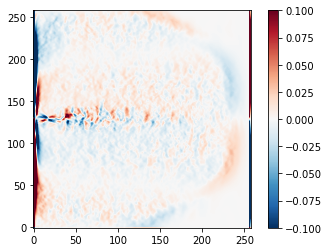

In [35]:
fig, ax = plt.subplots()
im = ax.imshow(P3x[0], origin='lower', vmax=.1, vmin=-.1, cmap='RdBu_r')
fig.colorbar(im)

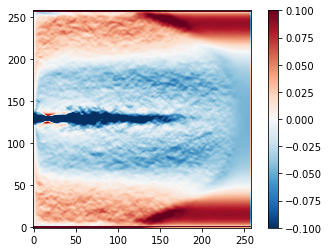

In [36]:
fig, ax = plt.subplots()
im = ax.imshow(P3y[0], origin='lower', vmax=.1, vmin=-.1, cmap='RdBu_r')
fig.colorbar(im)

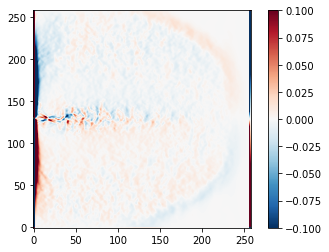

In [35]:
fig, ax = plt.subplots()
im = ax.imshow(P1x[0], origin='lower', vmax=.1, vmin=-.1, cmap='RdBu_r')
fig.colorbar(im)

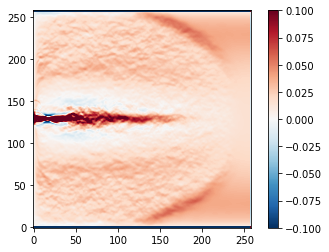

In [36]:
fig, ax = plt.subplots()
im = ax.imshow(P1y[0], origin='lower', vmax=.1, vmin=-.1, cmap='RdBu_r')
fig.colorbar(im)

In [11]:
def _dot(self, other):
    func = np.dot(self[0,0,0], other[0,0,0])
    return np.expand_dims(func, (0,1,2))

In [13]:
# clusters = np.concatenate((np.arange(5),np.arange(6,9)))
clusters = range(15)
Ppamp = xr.DataArray(np.zeros((4,nGMM)), dims=['tracer','cluster'],
                     coords={'tracer':range(4),'cluster':clusters}
                    )
gradPbm = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                       coords={'tracer':range(4),'cluster':clusters,
                               'orient':range(2)}
                      )
UpPpm = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                     coords={'tracer':range(4),'cluster':clusters,
                             'orient':range(2)}
                    )

for l in clusters:
#     if l == 0:
#         Ppamp.sel(cluster=l)[0] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP0p**2 + dsp1.vpP0p**2
#                                          ).where((dsc.cluster==l) | (dsc.cluster==5)
#                                                 ).isel(time=slice(None,-int(ntime/2))
#                                                       )).compressed())
#         Ppamp.sel(cluster=l)[1] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP1p**2 + dsp1.vpP1p**2
#                                          ).where((dsc.cluster==l) | (dsc.cluster==5)
#                                                 ).isel(time=slice(None,-int(ntime/2))
#                                                       )).compressed())
#         Ppamp.sel(cluster=l)[2] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP2p**2 + dsp1.vpP2p**2
#                                          ).where((dsc.cluster==l) | (dsc.cluster==5)
#                                                 ).isel(time=slice(None,-int(ntime/2))
#                                                       )).compressed())
#         Ppamp.sel(cluster=l)[3] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP3p**2 + dsp1.vpP3p**2
#                                          ).where((dsc.cluster==l) | (dsc.cluster==5)
#                                                 ).isel(time=slice(None,-int(ntime/2))
#                                                       )).compressed())

#         gradPbm.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(P0y.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(P0x.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(P1y.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(P1x.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(P2y.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(P2x.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(P3y.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(P3x.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())

#         UpPpm.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP0p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP0p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP1p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP1p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP2p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP2p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP3p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP3p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#     else:
    Ppamp.sel(cluster=l)[0] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP0p**2 + dsp1.vpP0p**2
                                         ).where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                     )).compressed())
    Ppamp.sel(cluster=l)[1] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP1p**2 + dsp1.vpP1p**2
                                         ).where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                     )).compressed())
    Ppamp.sel(cluster=l)[2] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP2p**2 + dsp1.vpP2p**2
                                         ).where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                     )).compressed())
    Ppamp.sel(cluster=l)[3] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP3p**2 + dsp1.vpP3p**2
                                         ).where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                     )).compressed())

    gradPbm.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(P0y.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(P0x.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(P1y.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(P1x.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(P2y.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(P2x.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(P3y.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())
    gradPbm.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(P3x.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                    )).compressed())

    UpPpm.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP0p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP0p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP1p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP1p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP2p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP2p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP3p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())
    UpPpm.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP3p.where(dsc.cluster==l).isel(time=slice(None,-int(ntime/2))
                                                                         )).compressed())

In [11]:
gradPbm.sel(tracer=1)

<xarray.DataArray (cluster: 15, orient: 2)>
array([[ 2.35175136e-02,  2.56538333e-05],
       [ 1.59100607e-01,  1.05638511e-03],
       [ 2.29305513e-02, -2.01370707e-03],
       [ 1.58791542e-02,  5.08356141e-04],
       [ 8.81254114e-03, -1.58587092e-04],
       [ 6.42026681e-03,  4.25624847e-03],
       [ 1.84757225e-02,  6.64472580e-04],
       [ 4.22697552e-02,  4.47142124e-03],
       [ 5.74733038e-03, -4.29714285e-03],
       [ 1.17355762e-02,  2.25878949e-03],
       [ 2.89539322e-02,  1.35421760e-05],
       [ 2.28652842e-02,  1.98194990e-03],
       [ 1.79124728e-01, -3.20461601e-01],
       [ 3.78307700e-02, -4.82527027e-03],
       [ 1.12795830e-02, -2.31701136e-03]])
Coordinates:
    tracer   int64 1
  * cluster  (cluster) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * orient   (orient) int64 0 1

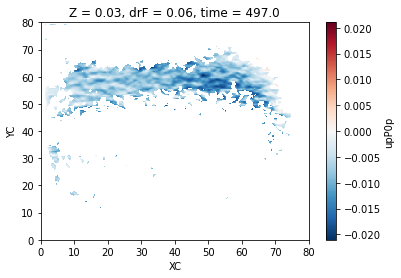

In [12]:
dsp1.upP0p.where(dsc.cluster==2).isel(time=0).plot()

In [13]:
for l in clusters:
#     if l == 0:
#         p0x_norm = xr.DataArray(np.ma.masked_invalid(((P0x.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                                        - gradPbm.sel(tracer=0,orient=1,cluster=l))
#                                                      * Ppamp.sel(tracer=0,cluster=l)**-1
#                                                     ).isel(time=slice(None,-int(ntime/2)))
#                                                    ).compressed(), 
#                                 dims=['YX'])
#         p0y_norm = xr.DataArray(np.ma.masked_invalid(((P0y.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                                        - gradPbm.sel(tracer=0,orient=0,cluster=l))
#                                                      * Ppamp.sel(tracer=0,cluster=l)**-1
#                                                     ).isel(time=slice(None,-int(ntime/2)))
#                                                    ).compressed(), 
#                                 dims=['YX'])


#         p1x_norm = xr.DataArray(np.ma.masked_invalid(((P1x.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                                        - gradPbm.sel(tracer=1,orient=1,cluster=l))
#                                                      * Ppamp.sel(tracer=1,cluster=l)**-1
#                                                     ).isel(time=slice(None,-int(ntime/2)))
#                                                    ).compressed(), 
#                                 dims=['YX'])
#         p1y_norm = xr.DataArray(np.ma.masked_invalid(((P1y.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                                        - gradPbm.sel(tracer=1,orient=0,cluster=l))
#                                                      * Ppamp.sel(tracer=1,cluster=l)**-1
#                                                     ).isel(time=slice(None,-int(ntime/2)))
#                                                    ).compressed(), 
#                                 dims=['YX'])


#         p2x_norm = xr.DataArray(np.ma.masked_invalid(((P2x.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                                        - gradPbm.sel(tracer=2,orient=1,cluster=l))
#                                                      * Ppamp.sel(tracer=2,cluster=l)**-1
#                                                     ).isel(time=slice(None,-int(ntime/2)))
#                                                    ).compressed(), 
#                                 dims=['YX'])
#         p2y_norm = xr.DataArray(np.ma.masked_invalid(((P2y.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                                        - gradPbm.sel(tracer=2,orient=0,cluster=l))
#                                                      * Ppamp.sel(tracer=2,cluster=l)**-1
#                                                     ).isel(time=slice(None,-int(ntime/2)))
#                                                    ).compressed(), 
#                                 dims=['YX'])


#         p3x_norm = xr.DataArray(np.ma.masked_invalid(((P3x.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                                        - gradPbm.sel(tracer=3,orient=1,cluster=l))
#                                                      * Ppamp.sel(tracer=3,cluster=l)**-1
#                                                     ).isel(time=slice(None,-int(ntime/2)))
#                                                    ).compressed(), 
#                                 dims=['YX'])
#         p3y_norm = xr.DataArray(np.ma.masked_invalid(((P3y.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                                        - gradPbm.sel(tracer=3,orient=0,cluster=l))
#                                                      * Ppamp.sel(tracer=3,cluster=l)**-1
#                                                     ).isel(time=slice(None,-int(ntime/2)))
#                                                    ).compressed(), 
#                                 dims=['YX'])
#     else:
    p0x_norm = xr.DataArray(np.ma.masked_invalid(((P0x.where(dsc.cluster==l) 
                                                       - gradPbm.sel(tracer=0,orient=1,cluster=l))
                                                     * Ppamp.sel(tracer=0,cluster=l)**-1
                                                    ).isel(time=slice(None,-int(ntime/2)))
                                                   ).compressed(), 
                                dims=['YX'])
    p0y_norm = xr.DataArray(np.ma.masked_invalid(((P0y.where(dsc.cluster==l) 
                                                       - gradPbm.sel(tracer=0,orient=0,cluster=l))
                                                     * Ppamp.sel(tracer=0,cluster=l)**-1
                                                    ).isel(time=slice(None,-int(ntime/2)))
                                                   ).compressed(), 
                                dims=['YX'])


    p1x_norm = xr.DataArray(np.ma.masked_invalid(((P1x.where(dsc.cluster==l) 
                                                       - gradPbm.sel(tracer=1,orient=1,cluster=l))
                                                     * Ppamp.sel(tracer=1,cluster=l)**-1
                                                    ).isel(time=slice(None,-int(ntime/2)))
                                                   ).compressed(), 
                                dims=['YX'])
    p1y_norm = xr.DataArray(np.ma.masked_invalid(((P1y.where(dsc.cluster==l) 
                                                       - gradPbm.sel(tracer=1,orient=0,cluster=l))
                                                     * Ppamp.sel(tracer=1,cluster=l)**-1
                                                    ).isel(time=slice(None,-int(ntime/2)))
                                                   ).compressed(), 
                                dims=['YX'])


    p2x_norm = xr.DataArray(np.ma.masked_invalid(((P2x.where(dsc.cluster==l) 
                                                       - gradPbm.sel(tracer=2,orient=1,cluster=l))
                                                     * Ppamp.sel(tracer=2,cluster=l)**-1
                                                    ).isel(time=slice(None,-int(ntime/2)))
                                                   ).compressed(), 
                                dims=['YX'])
    p2y_norm = xr.DataArray(np.ma.masked_invalid(((P2y.where(dsc.cluster==l) 
                                                       - gradPbm.sel(tracer=2,orient=0,cluster=l))
                                                     * Ppamp.sel(tracer=2,cluster=l)**-1
                                                    ).isel(time=slice(None,-int(ntime/2)))
                                                   ).compressed(), 
                                dims=['YX'])


    p3x_norm = xr.DataArray(np.ma.masked_invalid(((P3x.where(dsc.cluster==l) 
                                                       - gradPbm.sel(tracer=3,orient=1,cluster=l))
                                                     * Ppamp.sel(tracer=3,cluster=l)**-1
                                                    ).isel(time=slice(None,-int(ntime/2)))
                                                   ).compressed(), 
                                dims=['YX'])
    p3y_norm = xr.DataArray(np.ma.masked_invalid(((P3y.where(dsc.cluster==l) 
                                                       - gradPbm.sel(tracer=3,orient=0,cluster=l))
                                                     * Ppamp.sel(tracer=3,cluster=l)**-1
                                                    ).isel(time=slice(None,-int(ntime/2)))
                                                   ).compressed(), 
                                dims=['YX'])

#################################    
    YX = len(p0x_norm.YX)
    G = xr.DataArray(np.ones((int(YX*4),2))*np.nan,
                     dims=['tracer','orient'],
                     coords={'orient':range(2)}
                    )
    G[:YX,1] = -p0x_norm
    G[:YX,0] = -p0y_norm
    G[YX:int(2*YX),1] = -p1x_norm
    G[YX:int(2*YX),0] = -p1y_norm
    G[int(2*YX):int(3*YX),1] = -p2x_norm
    G[int(2*YX):int(3*YX),0] = -p2y_norm
    G[int(3*YX):,1] = -p3x_norm
    G[int(3*YX):,0] = -p3y_norm

################################# 
    invG = xr.DataArray(np.linalg.pinv(G), 
                        dims=['orient','tracer'],
                        coords={'orient':range(2)}
                       )
    dsave = invG.chunk({'tracer':100,'orient':-1}).to_dataset(name='Gdag')
    dsave.Gdag.encoding = {}
    if l == 0:
        print(dsave)
    dsave.to_zarr(op.join(ddir,'Gdag_%03d/nGMM%02d/%03d-%03d/Z%02d/cluster%02d.zarr'
                          % (ver,nGMM,int(312-ntime),int(312-ntime/2),iZ,l)),
                  mode='w')

    del invG
    print(l)

<xarray.Dataset>
Dimensions:  (orient: 2, tracer: 2694012)
Coordinates:
  * orient   (orient) int64 0 1
Dimensions without coordinates: tracer
Data variables:
    Gdag     (orient, tracer) float64 dask.array<chunksize=(2, 100), meta=np.ndarray>
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [27]:
ds = xr.tutorial.open_dataset("air_temperature")
# create initial chunk structure
ds = ds.chunk({'time': 100})
ds.air.encoding = {} # helps when writing to zarr
ds.to_zarr(ddir+'air_temperature.zarr')
source_group = zarr.open(ddir+'air_temperature.zarr')
print(source_group.tree())
source_array = source_group['air']
source_array.info

/
 ├── air (2920, 25, 53) float32
 ├── lat (25,) float32
 ├── lon (53,) float32
 └── time (2920,) float32


Name               : /air
Type               : zarr.core.Array
Data type          : float32
Shape              : (2920, 25, 53)
Chunk shape        : (100, 25, 53)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 15476000 (14.8M)
No. bytes stored   : 9005544 (8.6M)
Storage ratio      : 1.7
Chunks initialized : 30/30

In [14]:
max_mem = '1MB'
target_chunks_dict = {'time': 2920, 'lat': 25, 'lon': 1}

target_store = 'air_rechunked.zarr'
temp_store = 'air_rechunked-tmp.zarr'

array_plan = rechunk(source_array, target_chunks_dict, max_mem, target_store, temp_store=temp_store)

In [42]:
source_group = zarr.open(op.join(ddir,'G_%03d/%03d-%03d/Z%02d/cluster%02d.zarr'
                         % (ver,int(312-ntime),int(312-ntime/2),iZ,0))
             )
source_array = source_group['G']
source_array.info

Name               : /G
Type               : zarr.core.Array
Data type          : float64
Shape              : (815911, 4, 2)
Chunk shape        : (100, 4, 2)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : zarr.storage.DirectoryStore
No. bytes          : 52218304 (49.8M)
No. bytes stored   : 28220469 (26.9M)
Storage ratio      : 1.9
Chunks initialized : 8160/8160

In [43]:
import os
import shutil
if op.exists( op.join(ddir,"intermediate.zarr") ):
    shutil.rmtree(op.join(ddir,"intermediate.zarr"))

In [44]:
max_mem = '1MB'
target_chunks = {
        'G': {'YX':1, 'tracer':4, 'orient':2},
        'YX': None,
        'tracer': None,
        'orient': None}

if op.exists( op.join(ddir,"intermediate.zarr") ):
    shutil.rmtree(op.join(ddir,"intermediate.zarr"))
if op.exists( op.join(ddir,"target.zarr") ):
    shutil.rmtree(op.join(ddir,"target.zarr"))
target_store = ddir+'target.zarr'
temp_store = ddir+'intermediate.zarr'

array_plan = rechunk(source_array, target_chunks_dict, max_mem, target_store, temp_store=temp_store)
result = array_plan.execute()
result.chunks

(1, 4, 2)

In [46]:
for l in range(nGMM):
    source_group = zarr.open(op.join(ddir,'G_%03d/%03d-%03d/Z%02d/cluster%02d.zarr'
                             % (ver,int(312-ntime),int(312-ntime/2),iZ,l))
                 )
    source_array = source_group['G']
    if l == 0:
        print(G.tree())
            
    max_mem = '1MB'
    target_chunks = {
            'G': {'YX':1, 'tracer':4, 'orient':2},
            'YX': None,
            'tracer': None,
            'orient': None}

    if op.exists( op.join(ddir,"intermediate.zarr") ):
        shutil.rmtree( op.join(ddir,"intermediate.zarr") )
    if op.exists( op.join(ddir,"target.zarr") ):
        shutil.rmtree( op.join(ddir,"target.zarr") )
        
    target_store = ddir+'target.zarr'
    temp_store = ddir+'intermediate.zarr'
    array_plan = rechunk(source_array, target_chunks_dict, max_mem, target_store, temp_store=temp_store)
    rechunked = array_plan.execute()
    
    if l == 0:
        print(rechunked.chunks)
        
    invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                        rechunked),
                        dims=['YX','tracer','orient'],
                        coords={'tracer':range(4),'orient':range(2)}
                       )
    dsave = invG.to_dataset(name='Gdag')
    dsave.invG.encoding = {}
    dsave.to_zarr(op.join(ddir,'Gdag_%03d/%02d-%02d/Z%02d/cluster%02d.zarr'
                                                 % (ver,312-ntime,312-int(ntime/2),iZ,l)),
                                         mode='w')
    del invG
    print(l)

/
 ├── G (815911, 4, 2) float64
 ├── orient (2,) int64
 └── tracer (4,) int64
(1, 4, 2)


ValueError: different number of dimensions on data and dims: 0 vs 3

In [14]:
K = xr.DataArray(np.ones((nGMM,2,2))*np.nan,
                 dims=['cluster','row','orient'],
                 coords={'cluster':clusters,
                         'orient':range(2)
                        }
                )

In [15]:
for l in clusters:
    
    invG = xr.open_zarr(op.join(ddir,'Gdag_%03d/nGMM%02d/%02d-%02d/Z%02d/cluster%02d.zarr'
                                % (ver,nGMM,312-ntime,312-int(ntime/2),iZ,l))
                       ).Gdag
    
#################################
#     if l == 0:
#         up0_norm = np.ma.masked_invalid(((dsp1.upP0p.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                           - UpPpm.sel(tracer=0,orient=1,cluster=l))
#                                          * Ppamp.sel(tracer=0,cluster=l)**-1
#                                         ).isel(time=slice(None,-int(ntime/2)))
#                                        ).compressed()
#         vp0_norm = np.ma.masked_invalid(((dsp1.vpP0p.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                           - UpPpm.sel(tracer=0,orient=0,cluster=l))
#                                          * Ppamp.sel(tracer=0,cluster=l)**-1
#                                         ).isel(time=slice(None,-int(ntime/2)))
#                                        ).compressed()


#         up1_norm = np.ma.masked_invalid(((dsp1.upP1p.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                           - UpPpm.sel(tracer=1,orient=1,cluster=l))
#                                          * Ppamp.sel(tracer=1,cluster=l)**-1
#                                         ).isel(time=slice(None,-int(ntime/2)))
#                                        ).compressed()
#         vp1_norm = np.ma.masked_invalid(((dsp1.vpP1p.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                           - UpPpm.sel(tracer=1,orient=0,cluster=l))
#                                          * Ppamp.sel(tracer=1,cluster=l)**-1
#                                         ).isel(time=slice(None,-int(ntime/2)))
#                                        ).compressed()


#         up2_norm = np.ma.masked_invalid(((dsp1.upP2p.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                           - UpPpm.sel(tracer=2,orient=1,cluster=l))
#                                          * Ppamp.sel(tracer=2,cluster=l)**-1
#                                         ).isel(time=slice(None,-int(ntime/2)))
#                                        ).compressed()
#         vp2_norm = np.ma.masked_invalid(((dsp1.vpP2p.where((dsc.cluster==l) | (dsc.cluster==5))
#                                           - UpPpm.sel(tracer=2,orient=0,cluster=l))
#                                          * Ppamp.sel(tracer=2,cluster=l)**-1
#                                         ).isel(time=slice(None,-int(ntime/2)))
#                                        ).compressed()


#         up3_norm = np.ma.masked_invalid(((dsp1.upP3p.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                           - UpPpm.sel(tracer=3,orient=1,cluster=l))
#                                          * Ppamp.sel(tracer=3,cluster=l)**-1
#                                         ).isel(time=slice(None,-int(ntime/2)))
#                                        ).compressed()
#         vp3_norm = np.ma.masked_invalid(((dsp1.vpP3p.where((dsc.cluster==l) | (dsc.cluster==5)) 
#                                           - UpPpm.sel(tracer=3,orient=0,cluster=l))
#                                          * Ppamp.sel(tracer=3,cluster=l)**-1
#                                         ).isel(time=slice(None,-int(ntime/2)))
#                                        ).compressed()
#     else:
    up0_norm = np.ma.masked_invalid(((dsp1.upP0p.where(dsc.cluster==l) 
                                          - UpPpm.sel(tracer=0,orient=1,cluster=l))
                                         * Ppamp.sel(tracer=0,cluster=l)**-1
                                        ).isel(time=slice(None,-int(ntime/2)))
                                       ).compressed()
    vp0_norm = np.ma.masked_invalid(((dsp1.vpP0p.where(dsc.cluster==l) 
                                          - UpPpm.sel(tracer=0,orient=0,cluster=l))
                                         * Ppamp.sel(tracer=0,cluster=l)**-1
                                        ).isel(time=slice(None,-int(ntime/2)))
                                       ).compressed()


    up1_norm = np.ma.masked_invalid(((dsp1.upP1p.where(dsc.cluster==l) 
                                          - UpPpm.sel(tracer=1,orient=1,cluster=l))
                                         * Ppamp.sel(tracer=1,cluster=l)**-1
                                        ).isel(time=slice(None,-int(ntime/2)))
                                       ).compressed()
    vp1_norm = np.ma.masked_invalid(((dsp1.vpP1p.where(dsc.cluster==l) 
                                          - UpPpm.sel(tracer=1,orient=0,cluster=l))
                                         * Ppamp.sel(tracer=1,cluster=l)**-1
                                        ).isel(time=slice(None,-int(ntime/2)))
                                       ).compressed()


    up2_norm = np.ma.masked_invalid(((dsp1.upP2p.where(dsc.cluster==l) 
                                          - UpPpm.sel(tracer=2,orient=1,cluster=l))
                                         * Ppamp.sel(tracer=2,cluster=l)**-1
                                        ).isel(time=slice(None,-int(ntime/2)))
                                       ).compressed()
    vp2_norm = np.ma.masked_invalid(((dsp1.vpP2p.where(dsc.cluster==l) 
                                          - UpPpm.sel(tracer=2,orient=0,cluster=l))
                                         * Ppamp.sel(tracer=2,cluster=l)**-1
                                        ).isel(time=slice(None,-int(ntime/2)))
                                       ).compressed()


    up3_norm = np.ma.masked_invalid(((dsp1.upP3p.where(dsc.cluster==l) 
                                          - UpPpm.sel(tracer=3,orient=1,cluster=l))
                                         * Ppamp.sel(tracer=3,cluster=l)**-1
                                        ).isel(time=slice(None,-int(ntime/2)))
                                       ).compressed()
    vp3_norm = np.ma.masked_invalid(((dsp1.vpP3p.where(dsc.cluster==l) 
                                          - UpPpm.sel(tracer=3,orient=0,cluster=l))
                                         * Ppamp.sel(tracer=3,cluster=l)**-1
                                        ).isel(time=slice(None,-int(ntime/2)))
                                       ).compressed()

#################################
    YX = len(up0_norm)
    F = xr.DataArray(np.ones((int(YX*4),2))*np.nan,
                     dims=['tracer','orient'],
                     coords={'orient':range(2)}
                    )
    F[:YX,1] = up0_norm
    F[:YX,0] = vp0_norm
    F[YX:int(2*YX),1] = up1_norm
    F[YX:int(2*YX),0] = vp1_norm
    F[int(2*YX):int(3*YX),1] = up2_norm
    F[int(2*YX):int(3*YX),0] = vp2_norm
    F[int(3*YX):,1] = up3_norm
    F[int(3*YX):,0] = vp3_norm
    
    K.sel(cluster=l)[:] = np.dot(invG, F)
    if l == 0:
        print(K.sel(cluster=l))
    print(l)
    
#################################
dsave = K.to_dataset(name='K')
dsave.to_zarr(op.join(ddir,'K_%03d/nGMM%02d/%03d-%03d/Z%02d.zarr'
                      % (ver,nGMM,int(312-ntime),int(312-ntime/2),iZ)),
              mode='w')
dsave.close()

<xarray.DataArray (row: 2, orient: 2)>
array([[0.01118819, 0.0005601 ],
       [0.00485198, 0.02799658]])
Coordinates:
    cluster  int64 0
  * orient   (orient) int64 0 1
Dimensions without coordinates: row
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [9]:
# clusters = np.concatenate((np.arange(5),np.arange(6,9)))
clusters = range(15)
Ppamp1 = xr.DataArray(np.zeros((4,nGMM)), dims=['tracer','cluster'],
                     coords={'tracer':range(4),'cluster':clusters}
                    )
gradPbm1 = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                       coords={'tracer':range(4),'cluster':clusters,
                               'orient':range(2)}
                      )
UpPpm1 = xr.DataArray(np.zeros((4,nGMM,2)), dims=['tracer','cluster','orient'],
                     coords={'tracer':range(4),'cluster':clusters,
                             'orient':range(2)}
                    )

for l in clusters:
#     if l == 0:
#         Ppamp.sel(cluster=l)[0] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP0p**2 + dsp1.vpP0p**2
#                                          ).where((dsc.cluster==l) | (dsc.cluster==5)
#                                                 ).isel(time=slice(None,-int(ntime/2))
#                                                       )).compressed())
#         Ppamp.sel(cluster=l)[1] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP1p**2 + dsp1.vpP1p**2
#                                          ).where((dsc.cluster==l) | (dsc.cluster==5)
#                                                 ).isel(time=slice(None,-int(ntime/2))
#                                                       )).compressed())
#         Ppamp.sel(cluster=l)[2] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP2p**2 + dsp1.vpP2p**2
#                                          ).where((dsc.cluster==l) | (dsc.cluster==5)
#                                                 ).isel(time=slice(None,-int(ntime/2))
#                                                       )).compressed())
#         Ppamp.sel(cluster=l)[3] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP3p**2 + dsp1.vpP3p**2
#                                          ).where((dsc.cluster==l) | (dsc.cluster==5)
#                                                 ).isel(time=slice(None,-int(ntime/2))
#                                                       )).compressed())

#         gradPbm.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(P0y.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(P0x.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(P1y.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(P1x.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(P2y.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(P2x.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(P3y.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         gradPbm.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(P3x.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                ).isel(time=slice(None,-int(ntime/2)))).compressed())

#         UpPpm.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP0p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP0p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP1p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP1p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP2p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP2p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP3p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#         UpPpm.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP3p.where((dsc.cluster==l) | (dsc.cluster==5)
#                                                     ).isel(time=slice(None,-int(ntime/2)))).compressed())
#     else:
    Ppamp1.sel(cluster=l)[0] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP0p**2 + dsp1.vpP0p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())
    Ppamp1.sel(cluster=l)[1] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP1p**2 + dsp1.vpP1p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())
    Ppamp1.sel(cluster=l)[2] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP2p**2 + dsp1.vpP2p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())
    Ppamp1.sel(cluster=l)[3] = np.nanmedian(np.ma.masked_invalid(np.sqrt(dsp1.upP3p**2 + dsp1.vpP3p**2
                                         ).where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                     )).compressed())

    gradPbm1.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(P0y.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(P0x.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(P1y.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(P1x.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(P2y.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(P2x.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(P3y.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())
    gradPbm1.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(P3x.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                    )).compressed())

    UpPpm1.sel(cluster=l)[0,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP0p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[0,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP0p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[1,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP1p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[1,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP1p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[2,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP2p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[2,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP2p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[3,0] = np.nanmedian(np.ma.masked_invalid(dsp1.vpP3p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())
    UpPpm1.sel(cluster=l)[3,1] = np.nanmedian(np.ma.masked_invalid(dsp1.upP3p.where(dsc.cluster==l).isel(time=slice(-int(ntime/2),None)
                                                                         )).compressed())

In [10]:
K = xr.open_zarr(op.join(ddir,'K_%03d/nGMM%02d/%03d-%03d/Z%02d.zarr'
                         % (ver,nGMM,int(312-ntime),int(312-ntime/2),iZ))
                )
K.load() * (Rd*U)

<xarray.Dataset>
Dimensions:  (cluster: 15, orient: 2, row: 2)
Coordinates:
  * cluster  (cluster) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * orient   (orient) int64 0 1
Dimensions without coordinates: row
Data variables:
    K        (cluster, row, orient) float64 55.94 2.8 24.26 ... 9.937 428.9

In [11]:
Pyx = xr.DataArray(np.zeros((63,256,256,2,4,nGMM)),
                   dims=['time','YC','XC','orient','tracer','cluster'],
                   coords={'time':dsc.time.isel(time=slice(-int(ntime/2),None)),
                           'YC':dsc.YC,'XC':dsc.XC,
                           'orient':range(2),'tracer':range(4),
                           'cluster':clusters}
                  )

for l in clusters:
#     if l == 0:
#         Pyx.sel(tracer=0,cluster=l)[:] = xr.concat([((P0y.where((dsc.cluster==0) | (dsc.cluster==5)
#                                                                ).isel(time=slice(None,-int(ntime/2))) 
#                                                       - gradPbm.sel(orient=0,tracer=0,cluster=0))
#                                                     * Ppamp.sel(tracer=0,cluster=0)**-1),
#                                                    ((P0x.where((dsc.cluster==0) | (dsc.cluster==5)
#                                                               ).isel(time=slice(None,-int(ntime/2))) 
#                                                      - gradPbm.sel(tracer=0,cluster=0,orient=1))
#                                                     * Ppamp.sel(tracer=0,cluster=0)**-1)
#                                                   ], 'orient'
#                                                  ).transpose('time','YC','XC','orient')
#         Pyx.sel(tracer=1,cluster=l)[:] = xr.concat([((P1y.where((dsc.cluster==0) | (dsc.cluster==5)
#                                                                ).isel(time=slice(None,-int(ntime/2))) 
#                                                       - gradPbm.sel(orient=0,tracer=1,cluster=0))
#                                                     * Ppamp.sel(tracer=1,cluster=0)**-1),
#                                                    ((P1x.where((dsc.cluster==0) | (dsc.cluster==5)
#                                                               ).isel(time=slice(None,-int(ntime/2))) 
#                                                      - gradPbm.sel(orient=1,tracer=1,cluster=0))
#                                                     * Ppamp.sel(tracer=1,cluster=0)**-1)
#                                                   ], 'orient'
#                                                  ).transpose('time','YC','XC','orient')
#         Pyx.sel(tracer=2,cluster=l)[:] = xr.concat([((P2y.where((dsc.cluster==0) | (dsc.cluster==5)
#                                                                ).isel(time=slice(None,-int(ntime/2))) 
#                                                       - gradPbm.isel(orient=0,tracer=2,cluster=0))
#                                                     * Ppamp.sel(tracer=2,cluster=0)**-1),
#                                                    ((P2x.where((dsc.cluster==0) | (dsc.cluster==5)
#                                                               ).isel(time=slice(None,-int(ntime/2))) 
#                                                      - gradPbm.sel(tracer=2,cluster=0,orient=1))
#                                                     * Ppamp.sel(tracer=2,cluster=0)**-1)
#                                                   ], 'orient'
#                                                  ).transpose('time','YC','XC','orient')
#         Pyx.sel(tracer=3,cluster=l)[:] = xr.concat([((P3y.where((dsc.cluster==0) | (dsc.cluster==5)
#                                                                ).isel(time=slice(None,-int(ntime/2)))
#                                                       - gradPbm.sel(tracer=3,cluster=0,orient=0))
#                                                     * Ppamp.sel(tracer=3,cluster=0)**-1),
#                                                    ((P3x.where((dsc.cluster==0) | (dsc.cluster==5)
#                                                               ).isel(time=slice(None,-int(ntime/2))) 
#                                                      - gradPbm.sel(tracer=3,cluster=0,orient=1))
#                                                     * Ppamp.sel(tracer=3,cluster=0)**-1)
#                                                   ], 'orient'
#                                                  ).transpose('time','YC','XC','orient')
#     else:
    Pyx.sel(tracer=0,cluster=l)[:] = xr.concat([((P0y.where(dsc.cluster==l
                                                               ).isel(time=slice(-int(ntime/2),None)) 
                                                      - gradPbm1.sel(tracer=0,cluster=l,orient=0))
                                                    * Ppamp1.sel(tracer=0,cluster=l)**-1),
                                                   ((P0x.where(dsc.cluster==l
                                                              ).isel(time=slice(-int(ntime/2),None))
                                                     - gradPbm1.sel(tracer=0,cluster=l,orient=1))
                                                    * Ppamp1.sel(tracer=0,cluster=l)**-1)
                                                  ], 'orient'
                                                 ).transpose('time','YC','XC','orient')
    Pyx.sel(tracer=1,cluster=l)[:] = xr.concat([((P1y.where(dsc.cluster==l
                                                               ).isel(time=slice(-int(ntime/2),None)) 
                                                      - gradPbm1.sel(tracer=1,cluster=l,orient=0))
                                                    * Ppamp1.sel(tracer=1,cluster=l)**-1),
                                                   ((P1x.where(dsc.cluster==l
                                                              ).isel(time=slice(-int(ntime/2),None)) 
                                                     - gradPbm1.sel(tracer=1,cluster=l,orient=1))
                                                    * Ppamp1.sel(tracer=1,cluster=l)**-1)
                                                  ], 'orient'
                                                 ).transpose('time','YC','XC','orient')
    Pyx.sel(tracer=2,cluster=l)[:] = xr.concat([((P2y.where(dsc.cluster==l
                                                               ).isel(time=slice(-int(ntime/2),None)) 
                                                      - gradPbm1.sel(tracer=2,cluster=l,orient=0))
                                                    * Ppamp1.sel(tracer=2,cluster=l)**-1),
                                                   ((P2x.where(dsc.cluster==l
                                                              ).isel(time=slice(-int(ntime/2),None)) 
                                                     - gradPbm1.sel(tracer=2,cluster=l,orient=1))
                                                    * Ppamp1.sel(tracer=2,cluster=l)**-1)
                                                  ], 'orient'
                                                 ).transpose('time','YC','XC','orient')
    Pyx.sel(tracer=3,cluster=l)[:] = xr.concat([((P3y.where(dsc.cluster==l
                                                               ).isel(time=slice(-int(ntime/2),None)) 
                                                      - gradPbm1.sel(tracer=3,cluster=l,orient=0))
                                                    * Ppamp1.sel(tracer=3,cluster=l)**-1),
                                                   ((P3x.where(dsc.cluster==l
                                                              ).isel(time=slice(-int(ntime/2),None))
                                                     - gradPbm1.sel(tracer=3,cluster=l,orient=1))
                                                    * Ppamp1.sel(tracer=3,cluster=l)**-1)
                                                  ], 'orient'
                                                 ).transpose('time','YC','XC','orient')

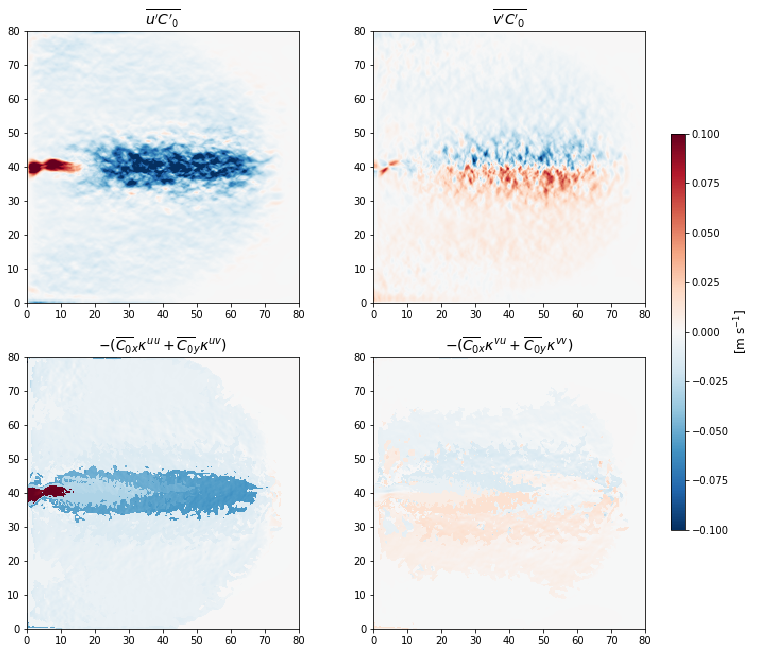

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsp1.XC, dsp1.YC,
                  dsp1.upP0p.isel(time=-int(ntime/2)),
                  vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True)
axes[0,1].pcolormesh(dsp1.XC, dsp1.YC,
                  dsp1.vpP0p.isel(time=-int(ntime/2)),
                  vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True)

for l in clusters:
#     if l == 0:
#         mask = np.ma.masked_invalid(Pyx.isel(time=0).sel(tracer=0,cluster=0,orient=0)).mask
#         im = ax.pcolormesh(dsp1.XC, dsp1.YC,
#                            np.ma.masked_array(np.dot(Pyx.isel(time=0).sel(tracer=0,cluster=0), K.sel(cluster=0).to_array())[...,0,1]
#                                               * Ppamp.sel(tracer=0,cluster=0).data
#                                               + UpPpm.sel(tracer=0,cluster=0,orient=1).data, mask), 
#                            vmax=.1, vmin=-.1, cmap='seismic')
#     else:
    mask = np.ma.masked_invalid(dsc.cluster.where(dsc.cluster==l).isel(time=-int(ntime/2)).data).mask
    axes[1,1].pcolormesh(dsp1.XC, dsp1.YC,
                      np.ma.masked_array(np.dot(Pyx.isel(time=-int(ntime/2)).sel(tracer=0,cluster=l), 
                                                K.sel(cluster=l).to_array())[...,0,0]
                                         * Ppamp1.sel(tracer=0,cluster=l).data
                                         + UpPpm1.sel(tracer=0,cluster=l,orient=0).data, mask), 
                      vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True
        )
    axes[1,0].pcolormesh(dsp1.XC, dsp1.YC,
                      np.ma.masked_array(np.dot(Pyx.isel(time=-int(ntime/2)).sel(tracer=0,cluster=l), 
                                                K.sel(cluster=l).to_array())[...,0,1]
                                         * Ppamp1.sel(tracer=0,cluster=l).data
                                         + UpPpm1.sel(tracer=0,cluster=l,orient=1).data, mask), 
                      vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True
        )
    
axes[0,0].set_title(r"$\overline{u'C'_0}$", fontsize=14)
axes[0,1].set_title(r"$\overline{v'C'_0}$", fontsize=14)
axes[1,0].set_title(r"$-(\overline{C_0}_x\kappa^{uu}+\overline{C_0}_y\kappa^{uv})$", fontsize=14)
axes[1,1].set_title(r"$-(\overline{C_0}_x\kappa^{vu}+\overline{C_0}_y\kappa^{vv})$", fontsize=14)
    
axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figs/Ptr0_LINr_cluster-%02d_5thyear_00.pdf' % nGMM))

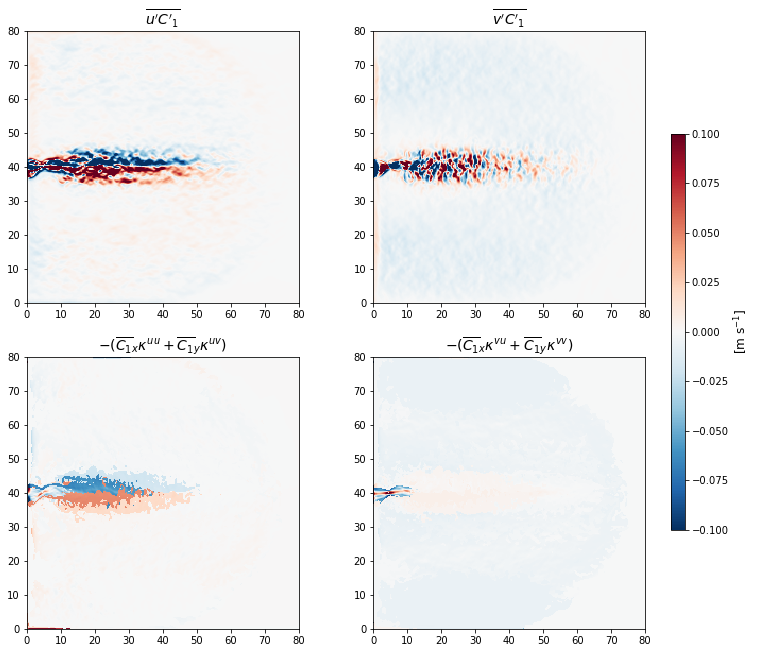

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsp1.XC, dsp1.YC,
                  dsp1.upP1p.isel(time=-int(ntime/2)),
                  vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True)
axes[0,1].pcolormesh(dsp1.XC, dsp1.YC,
                  dsp1.vpP1p.isel(time=-int(ntime/2)),
                  vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True)

for l in clusters:
#     if l == 0:
#         mask = np.ma.masked_invalid(Pyx.isel(time=0).sel(tracer=0,cluster=0,orient=0)).mask
#         im = ax.pcolormesh(dsp1.XC, dsp1.YC,
#                            np.ma.masked_array(np.dot(Pyx.isel(time=0).sel(tracer=0,cluster=0), K.sel(cluster=0).to_array())[...,0,1]
#                                               * Ppamp.sel(tracer=0,cluster=0).data
#                                               + UpPpm.sel(tracer=0,cluster=0,orient=1).data, mask), 
#                            vmax=.1, vmin=-.1, cmap='seismic')
#     else:
    mask = np.ma.masked_invalid(dsc.cluster.where(dsc.cluster==l).isel(time=-int(ntime/2)).data).mask
    axes[1,1].pcolormesh(dsp1.XC, dsp1.YC,
                      np.ma.masked_array(np.dot(Pyx.isel(time=-int(ntime/2)).sel(tracer=1,cluster=l), 
                                                K.sel(cluster=l).to_array())[...,0,0]
                                         * Ppamp1.sel(tracer=1,cluster=l).data
                                         + UpPpm1.sel(tracer=1,cluster=l,orient=0).data, mask), 
                      vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True
        )
    axes[1,0].pcolormesh(dsp1.XC, dsp1.YC,
                      np.ma.masked_array(np.dot(Pyx.isel(time=-int(ntime/2)).sel(tracer=1,cluster=l), 
                                                K.sel(cluster=l).to_array())[...,0,1]
                                         * Ppamp1.sel(tracer=1,cluster=l).data
                                         + UpPpm1.sel(tracer=1,cluster=l,orient=1).data, mask), 
                      vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True
        )

axes[0,0].set_title(r"$\overline{u'C'_1}$", fontsize=14)
axes[0,1].set_title(r"$\overline{v'C'_1}$", fontsize=14)
axes[1,0].set_title(r"$-(\overline{C_1}_x\kappa^{uu}+\overline{C_1}_y\kappa^{uv})$", fontsize=14)
axes[1,1].set_title(r"$-(\overline{C_1}_x\kappa^{vu}+\overline{C_1}_y\kappa^{vv})$", fontsize=14)
    
axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figs/Ptr1_LINr_cluster-%02d_5thyear_00.pdf' % nGMM))

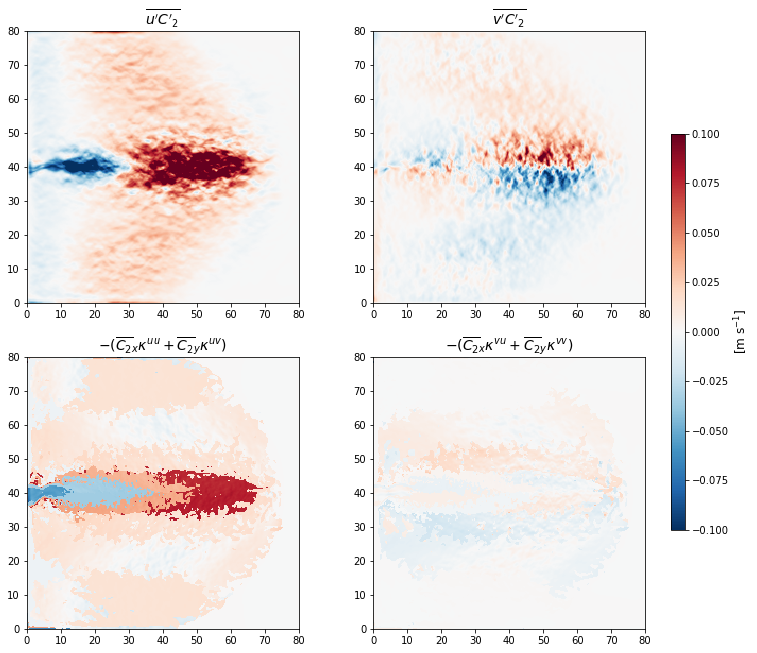

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsp1.XC, dsp1.YC,
                          dsp1.upP2p.isel(time=-int(ntime/2)),
                          vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True)
axes[0,1].pcolormesh(dsp1.XC, dsp1.YC,
                     dsp1.vpP2p.isel(time=-int(ntime/2)),
                     vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True)

for l in clusters:
#     if l == 0:
#         mask = np.ma.masked_invalid(Pyx.isel(time=0).sel(tracer=0,cluster=0,orient=0)).mask
#         im = ax.pcolormesh(dsp1.XC, dsp1.YC,
#                            np.ma.masked_array(np.dot(Pyx.isel(time=0).sel(tracer=0,cluster=0), K.sel(cluster=0).to_array())[...,0,1]
#                                               * Ppamp.sel(tracer=0,cluster=0).data
#                                               + UpPpm.sel(tracer=0,cluster=0,orient=1).data, mask), 
#                            vmax=.1, vmin=-.1, cmap='seismic')
#     else:
    mask = np.ma.masked_invalid(dsc.cluster.where(dsc.cluster==l).isel(time=-int(ntime/2)).data).mask
    axes[1,1].pcolormesh(dsp1.XC, dsp1.YC,
                      np.ma.masked_array(np.dot(Pyx.isel(time=-int(ntime/2)).sel(tracer=2,cluster=l), 
                                                K.sel(cluster=l).to_array())[...,0,0]
                                         * Ppamp1.sel(tracer=2,cluster=l).data
                                         + UpPpm1.sel(tracer=2,cluster=l,orient=0).data, mask), 
                      vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True
        )
    axes[1,0].pcolormesh(dsp1.XC, dsp1.YC,
                      np.ma.masked_array(np.dot(Pyx.isel(time=-int(ntime/2)).sel(tracer=2,cluster=l), 
                                                K.sel(cluster=l).to_array())[...,0,1]
                                         * Ppamp1.sel(tracer=2,cluster=l).data
                                         + UpPpm1.sel(tracer=2,cluster=l,orient=1).data, mask), 
                      vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True
        )

axes[0,0].set_title(r"$\overline{u'C'_2}$", fontsize=14)
axes[0,1].set_title(r"$\overline{v'C'_2}$", fontsize=14)
axes[1,0].set_title(r"$-(\overline{C_2}_x\kappa^{uu}+\overline{C_2}_y\kappa^{uv})$", fontsize=14)
axes[1,1].set_title(r"$-(\overline{C_2}_x\kappa^{vu}+\overline{C_2}_y\kappa^{vv})$", fontsize=14)    

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figs/Ptr2_LINr_cluster-%02d_5thyear_00.pdf' % nGMM))

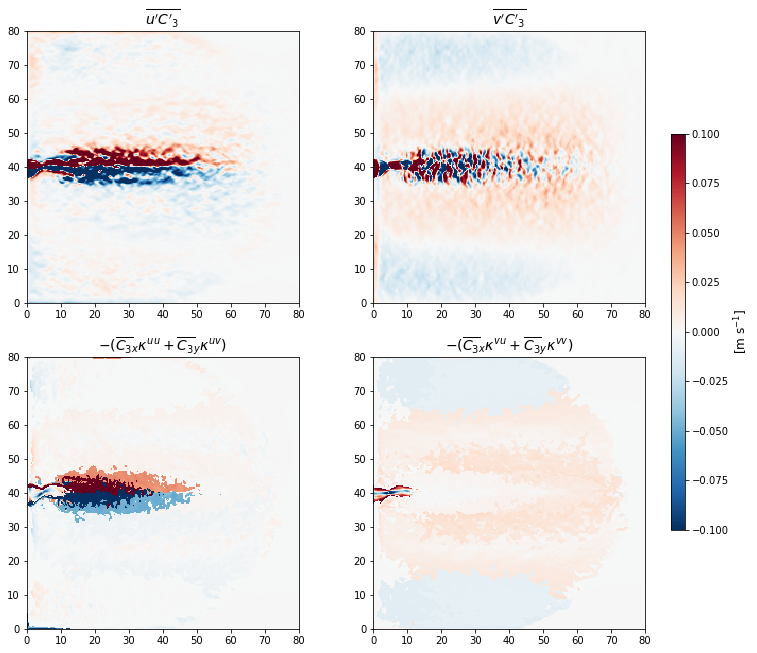

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,11))

im = axes[0,0].pcolormesh(dsp1.XC, dsp1.YC,
                  dsp1.upP3p.isel(time=-int(ntime/2)),
                  vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True)
axes[0,1].pcolormesh(dsp1.XC, dsp1.YC,
                  dsp1.vpP3p.isel(time=-int(ntime/2)),
                  vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True)

for l in clusters:
#     if l == 0:
#         mask = np.ma.masked_invalid(Pyx.isel(time=0).sel(tracer=0,cluster=0,orient=0)).mask
#         im = ax.pcolormesh(dsp1.XC, dsp1.YC,
#                            np.ma.masked_array(np.dot(Pyx.isel(time=0).sel(tracer=0,cluster=0), K.sel(cluster=0).to_array())[...,0,1]
#                                               * Ppamp.sel(tracer=0,cluster=0).data
#                                               + UpPpm.sel(tracer=0,cluster=0,orient=1).data, mask), 
#                            vmax=.1, vmin=-.1, cmap='seismic')
#     else:
    mask = np.ma.masked_invalid(Pyx.isel(time=-int(ntime/2)).sel(tracer=3,cluster=l,orient=0)).mask
    axes[1,1].pcolormesh(dsp1.XC, dsp1.YC,
                      np.ma.masked_array(np.dot(Pyx.isel(time=-int(ntime/2)).sel(tracer=3,cluster=l), 
                                                K.sel(cluster=l).to_array())[...,0,0]
                                         * Ppamp1.sel(tracer=3,cluster=l).data
                                         + UpPpm1.sel(tracer=3,cluster=l,orient=0).data, mask), 
                      vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True
        )
    mask = np.ma.masked_invalid(Pyx.isel(time=-int(ntime/2)).sel(tracer=3,cluster=l,orient=1)).mask
    axes[1,0].pcolormesh(dsp1.XC, dsp1.YC,
                      np.ma.masked_array(np.dot(Pyx.isel(time=-int(ntime/2)).sel(tracer=3,cluster=l), 
                                                K.sel(cluster=l).to_array())[...,0,1]
                                         * Ppamp1.sel(tracer=3,cluster=l).data
                                         + UpPpm1.sel(tracer=3,cluster=l,orient=1).data, mask), 
                      vmax=.1, vmin=-.1, cmap='RdBu_r', shading='auto', rasterized=True
        )

axes[0,0].set_title(r"$\overline{u'C'_3}$", fontsize=14)
axes[0,1].set_title(r"$\overline{v'C'_3}$", fontsize=14)
axes[1,0].set_title(r"$-(\overline{C_3}_x\kappa^{uu}+\overline{C_3}_y\kappa^{uv})$", fontsize=14)
axes[1,1].set_title(r"$-(\overline{C_3}_x\kappa^{vu}+\overline{C_3}_y\kappa^{vv})$", fontsize=14)

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')
fig.subplots_adjust(right=0.86)
cbaxes = fig.add_axes([0.88, 0.25, 0.016, 0.5]) 
cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes,
#                     ticks=[-2.,-1.5,-1.,-.5,0.,.5,1.,1.5,2.]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r"[m s$^{-1}$]", fontsize=12)
plt.savefig(op.join(ddir,'Figs/Ptr3_LINr_cluster-%02d_5thyear_00.pdf' % nGMM))